In [1]:
#@title 1. MONTAR EL DRIVE  (If you are in in colab){ display-mode: "form" }
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/ia2_project')
print(os.getcwd())

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1ZVaIc7_d2UbXdolqFwAboCAl34UOyERP/ia2_project


# **General Libraries**

In [2]:
!pip install sentiment-analysis-spanish
!pip install tweet-preprocessor
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

     |████████████████████████████████| 30.0MB 92kB/s 


In [3]:
#@title Libraries

from sentiment_analysis_spanish import sentiment_analysis
sentiment = sentiment_analysis.SentimentAnalysisSpanish()
import datetime
from textblob import TextBlob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import collections
import tweepy
import nltk
import re
from nltk.corpus import stopwords
import preprocessor as p
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn import metrics

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MultinomialNB from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


# **Web Scrapping**

Para la obtención del dataset, utilizamos la técnica del Web Scrapping, la cual consiste básicamente en crear un bot que controle el navegador, con el fin de extraer la información requerida. En este caso, usamos Selenium.


<img src="https://www.antevenio.com/wp-content/uploads/2019/03/web.jpeg" />

## Creación del dataset de validación

In [ ]:
data1 = pd.read_csv('data/data_generator/tweets_covid_5236-2021-03-04.csv')
data2 = pd.read_csv('data/data_generator/tweets_covid_2241-2020-012-021.csv')
data3 = pd.read_csv('data/data_generator/tweets_covid_1083-2020-09-017.csv')
tweets_validation = pd.concat([data1,data2,data3])
tweets_validation.dropna(inplace=True)
tweets_validation.drop_duplicates(inplace=True)
tweets_validation.reset_index(drop=True, inplace=True)


In [ ]:
def cut_date(s):
  s = s[:10]
  return s

In [ ]:
tweets_validation["Fecha"] = tweets_validation["Fecha"].apply(cut_date)
date_format = "%Y/%m/%d"
tweets_validation["Fecha"] = pd.to_datetime(tweets_validation["Fecha"], format=date_format)
tweets_validation

,Nombre de usuario,Usuario,Fecha,Texto
0,Danesis,@DanesisArce,2021-03-04,La mejor vacuna contra el uribismo \n@CeDemocr...
1,Paula Ayala,@PaulaaAyala10,2021-03-04,Hoy me vacunaron contra el COVID. No dejo de p...
2,Alejandra Jiménez,@alejandrajc10,2021-03-04,Yo sí estoy de acuerdo con el señor de la ofic...
3,Julián Romero,@julianandres298,2021-03-04,Mis parcerxs docentes en Argentina ya están re...
4,FabianM,@MattoneFabian,2021-03-04,Che me jodes? Despues del choreo o Vacuna-Gate...
...,...,...,...,...
8508,Ells,@ellscms,2020-08-08,"Pregunta muy seria, ustedes se pondrían la vac..."
8509,J_Lozano.,@J_LozanoC,2020-08-08,Cuando llegue la vacuna a Colombia se imaginan...
8510,Jair G. Camargo R.,@ingeniero0013,2020-08-08,A pesar de haber sido los consentidos de la Na...
8511,Paradise.,@_DreamWorlds_,2020-08-08,¿Cuando va a llegar a Colombia la vacuna contr...


## Datos para el clasificador

### Creación del dataset con los tweets de #YoMeVacuno

In [ ]:
data_positiva = pd.read_csv('data/data_classifier/tweets/tweets_covid_positivo5054.csv')
data_positiva.dropna(inplace=True)
data_positiva.drop_duplicates(inplace=True)
data_positiva.reset_index(drop=True, inplace=True)

In [ ]:
fechas = data_positiva.Fecha
fechas

0       2021-03-06T17:27:16.000Z
1       2021-03-06T17:22:27.000Z
2       2021-03-06T17:13:20.000Z
3       2021-03-06T17:00:58.000Z
4       2021-03-06T17:00:23.000Z
                  ...           
5032    2021-01-27T16:53:12.000Z
5033    2021-01-27T16:52:56.000Z
5034    2021-01-27T16:47:44.000Z
5035    2021-01-27T16:42:38.000Z
5036    2021-01-27T16:41:29.000Z
Name: Fecha, Length: 5037, dtype: object

In [ ]:
for i in range(len(fechas)):
  fechas[i] = fechas[i][:10]

data_positiva["Fecha"] = fechas

In [ ]:
date_format = "%Y/%m/%d"
data_positiva["Fecha"] = pd.to_datetime(data_positiva["Fecha"], format=date_format)
data_positiva["Sentimiento"] = 1
data_positiva

,Nombre de usuario,Usuario,Fecha,Texto,Sentimiento
0,Aurora Fuentes,@paysandusiempre,2021-03-06,No dejen de mirar número de casos positivos d...,1
1,majo,@majoattacks,2021-03-06,#YoMeVacuno y todos los adultos mayores de mi ...,1
2,#YoApruebo,@xapahernandez,2021-03-06,"Hasta el Dalai Lama se vacunó, y todavía algun...",1
3,Ashishito\n#MascarillaBienPuesta,@jorgeapolaya,2021-03-06,#YoMeVacuno contra el terruqueo \n#YoMeVacuno ...,1
4,Jose Ragas,@joseragas,2021-03-06,Lo que hace Willax no es libertad de expresión...,1
...,...,...,...,...,...
5032,Isidora Elvira Molina,@PolymirII,2021-01-27,"#YoMeVacuno \nLa viruela, una enfermedad con u...",1
5033,𝓟𝓲𝓪,@joylaferte,2021-01-27,#YoMeVacuno no soy weona,1
5034,Britt Wallberg Núñez,@bwallbergn,2021-01-27,Soy grupo de riesgo y estoy extremando cuidado...,1
5035,dinosaurio,@paradoximon,2021-01-27,Hay cada uno que toma cocaína cortada con cual...,1


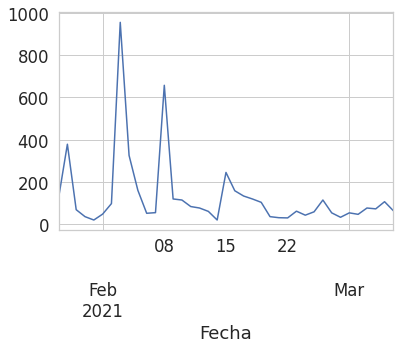

In [ ]:
data_positiva_fechas = data_positiva["Fecha"].groupby(data_positiva["Fecha"]).count()
data_positiva_fechas.sort_index
data_positiva_fechas.plot()

In [ ]:
data_positiva_fechas.sort_values(ascending=False)

Fecha
2021-02-03    957
2021-02-08    658
2021-01-28    378
2021-02-04    325
2021-02-15    244
2021-02-05    159
2021-02-16    157
2021-02-17    132
2021-01-27    123
2021-02-18    118
2021-02-09    118
2021-02-10    113
2021-02-26    113
2021-03-05    105
2021-02-19    102
2021-02-02     96
2021-02-11     82
2021-02-12     75
2021-03-03     75
2021-03-04     71
2021-01-29     67
2021-03-06     62
2021-02-23     60
2021-02-13     59
2021-02-25     57
2021-02-07     53
2021-02-27     52
2021-03-01     52
2021-02-06     50
2021-02-01     46
2021-03-02     45
2021-02-24     41
2021-02-20     34
2021-01-30     34
2021-02-28     31
2021-02-21     29
2021-02-22     28
2021-02-14     18
2021-01-31     18
Name: Fecha, dtype: int64

In [ ]:
data_positiva.to_csv('data/data_classifier/tweets_positivos.csv')

### Creación del dataset con los tweets de #YoNoMeVacuno

In [ ]:
data1= pd.read_csv('data/data_classifier/tweets/tweets_covid_negativo5085.csv')
data2 = pd.read_csv('data/data_classifier/tweets/tweets_covid_negativo3193.csv')
data_negativa = pd.concat([data1,data2])
data_negativa.dropna(inplace=True)
data_negativa.drop_duplicates(inplace=True)
data_negativa.reset_index(drop=True, inplace=True)
data_negativa.tail()

,Nombre de usuario,Usuario,Fecha,Texto
8194,Migue,@mikes_83,2020-11-03T01:16:45.000Z,#YoNoMeVacuno Mientras los macristas y anticua...
8195,mendieta\nfirpo,@mfirpo2021,2020-11-03T01:16:38.000Z,#YoNoMeVacuno \nestá claro que el inútil de \n...
8196,Mirta\nTod\ns,@mirtanicosia,2020-11-03T01:16:36.000Z,La mejor noticia! Alberto y Cristina demostran...
8197,Sergio_jl,@Sergiojl6,2020-11-03T01:16:36.000Z,#YoNoMeVacuno\nLos Rusos se saltearon la Fase ...
8198,TheLastDragon_98,@Albiceleste98,2020-11-03T01:16:33.000Z,"#YoNoMeVacuno ah pero, la cuarentena no sirve,..."


In [ ]:
fechas = data_negativa.Fecha
fechas

0       2021-03-06T02:58:42.000Z
1       2021-03-06T02:45:30.000Z
2       2021-03-06T01:03:54.000Z
3       2021-03-06T01:03:05.000Z
4       2021-03-05T21:59:34.000Z
                  ...           
8194    2020-11-03T01:16:45.000Z
8195    2020-11-03T01:16:38.000Z
8196    2020-11-03T01:16:36.000Z
8197    2020-11-03T01:16:36.000Z
8198    2020-11-03T01:16:33.000Z
Name: Fecha, Length: 8199, dtype: object

In [ ]:
for i in range(len(fechas)):
  fechas[i] = fechas[i][:10]

data_negativa["Fecha"] = fechas

In [ ]:
date_format = "%Y/%m/%d"
data_negativa["Fecha"] = pd.to_datetime(data_negativa["Fecha"], format=date_format)
data_negativa["Sentimiento"] = 0
data_negativa

,Nombre de usuario,Usuario,Fecha,Texto,Sentimiento
0,judi,@Judi_Arenaluza,2021-03-06,Vengo de mi cardio confieso que me topé con un...,0
1,Aerotiburon,@FREEEFALLLL,2021-03-06,#YoNoMeVacuno 11% y 33% de eficacia?..es ciert...,0
2,@LordDarthVader,@LordDarthVader,2021-03-06,Hoy es viernes y mi #YoNoMeVacuno lo sabe,0
3,Lord Vader,@mantisreligioso,2021-03-06,Tengo muy en claro que #YoNoMeVacuno,0
4,El Melena,@melelaborde,2021-03-05,"No importa la Vacuna , de que laboratorio , el...",0
...,...,...,...,...,...
8194,Migue,@mikes_83,2020-11-03,#YoNoMeVacuno Mientras los macristas y anticua...,0
8195,mendieta\nfirpo,@mfirpo2021,2020-11-03,#YoNoMeVacuno \nestá claro que el inútil de \n...,0
8196,Mirta\nTod\ns,@mirtanicosia,2020-11-03,La mejor noticia! Alberto y Cristina demostran...,0
8197,Sergio_jl,@Sergiojl6,2020-11-03,#YoNoMeVacuno\nLos Rusos se saltearon la Fase ...,0


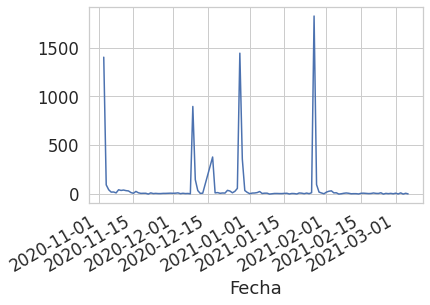

In [ ]:
fechas_negativas = data_negativa["Fecha"].groupby(data_negativa["Fecha"]).count()
fechas_negativas.sort_index
fechas_negativas.plot()

In [ ]:
fechas_negativas.sort_values(ascending=False)

Fecha
2021-01-27    1823
2020-12-28    1443
2020-11-03    1402
2020-12-09     898
2020-12-17     381
              ... 
2020-11-21       2
2021-02-06       2
2021-01-09       2
2021-03-04       2
2021-02-24       2
Name: Fecha, Length: 121, dtype: int64

In [ ]:
df_validation = pd.concat([data_negativa[(data_negativa["Fecha"]=='2021-01-27')],data_negativa[(data_negativa["Fecha"]=='2020-12-28')], data_negativa[(data_negativa["Fecha"]=='2020-11-03')],data_negativa[(data_negativa["Fecha"]=='2020-12-09')],]) 
#df_validation = df_validation[df_validation["Fecha"]=='2020-12-28']
#df_validation = df_validation[df_validation["Fecha"]=='2020-11-03']
#df_validation = df_validation[df_validation["Fecha"]=='2020-12-09']
df_validation.dropna(inplace=True)
df_validation.drop_duplicates(inplace=True)
df_validation.reset_index(drop=True, inplace=True)
df_validation = df_validation.drop('Sentimiento',1)
df_validation



,Nombre de usuario,Usuario,Fecha,Texto
0,Bautista Péntecost XY,@BautiPentecost,2021-01-27,Las vacunas matan gente y no lo están diciendo...
1,Némesis,@MaryBol95533136,2021-01-27,Aplicadores anales: La nueva forma del régime...
2,S A N T I,@diluidoenagua,2021-01-27,Me encanta que haya tanta gente diciendo #YoNo...
3,moon:),@luuunaaaaaaaae,2021-01-27,"Mejor, así los que nos queremos vacunar lo hac..."
4,Carlos.,@Carloscdc06,2021-01-27,¿#YoNoMeVacuno? \n\nComan mierda hptas.
...,...,...,...,...
5561,🅜🅡.🅝🅞🅑🅞🅓🅨,@Mr_N00b00dy,2020-12-09,"El hashtag #YoMeVacunare es trending, pero #Yo..."
5562,Lord Vader,@mantisreligioso,2020-12-09,LOS POLÍTICOS SON NUESTROS ENEMIGOS. #YoNoMeVa...
5563,Lord Vader,@mantisreligioso,2020-12-09,NO VACUNARSE. #YoNoMeVacuno
5564,@LordDarthVader,@LordDarthVader,2020-12-09,LOS POLÍTICOS SON NUESTROS ENEMIGOS. #YoNoMeVa...


In [ ]:
tweets_validation2 = pd.concat([df_validation,tweets_validation])
df_validation.dropna(inplace=True)
df_validation.drop_duplicates(inplace=True)
df_validation.reset_index(drop=True, inplace=True)
tweets_validation2.to_csv('data/data_classifier/tweets_validation.csv')
tweets_validation2

,Nombre de usuario,Usuario,Fecha,Texto
0,Bautista Péntecost XY,@BautiPentecost,2021-01-27,Las vacunas matan gente y no lo están diciendo...
1,Némesis,@MaryBol95533136,2021-01-27,Aplicadores anales: La nueva forma del régime...
2,S A N T I,@diluidoenagua,2021-01-27,Me encanta que haya tanta gente diciendo #YoNo...
3,moon:),@luuunaaaaaaaae,2021-01-27,"Mejor, así los que nos queremos vacunar lo hac..."
4,Carlos.,@Carloscdc06,2021-01-27,¿#YoNoMeVacuno? \n\nComan mierda hptas.
...,...,...,...,...
8508,Ells,@ellscms,2020-08-08,"Pregunta muy seria, ustedes se pondrían la vac..."
8509,J_Lozano.,@J_LozanoC,2020-08-08,Cuando llegue la vacuna a Colombia se imaginan...
8510,Jair G. Camargo R.,@ingeniero0013,2020-08-08,A pesar de haber sido los consentidos de la Na...
8511,Paradise.,@_DreamWorlds_,2020-08-08,¿Cuando va a llegar a Colombia la vacuna contr...


In [ ]:
df_negativos = data_negativa[data_negativa["Fecha"]!='2021-01-27'] 
df_negativos = df_negativos[df_negativos["Fecha"]!='2020-12-28']
df_negativos = df_negativos[df_negativos["Fecha"]!='2020-11-03']
df_negativos = df_negativos[df_negativos["Fecha"]!='2020-12-09']
df_negativos.dropna(inplace=True)
df_negativos.drop_duplicates(inplace=True)
df_negativos.reset_index(drop=True, inplace=True)
df_negativos

,Nombre de usuario,Usuario,Fecha,Texto,Sentimiento
0,judi,@Judi_Arenaluza,2021-03-06,Vengo de mi cardio confieso que me topé con un...,0
1,Aerotiburon,@FREEEFALLLL,2021-03-06,#YoNoMeVacuno 11% y 33% de eficacia?..es ciert...,0
2,@LordDarthVader,@LordDarthVader,2021-03-06,Hoy es viernes y mi #YoNoMeVacuno lo sabe,0
3,Lord Vader,@mantisreligioso,2021-03-06,Tengo muy en claro que #YoNoMeVacuno,0
4,El Melena,@melelaborde,2021-03-05,"No importa la Vacuna , de que laboratorio , el...",0
...,...,...,...,...,...
2622,lid,@ldutari,2020-11-04,#YoNoMeVacuno ni loca aunque sea obligatoria? ...,0
2623,Juan Manuel,@majud03,2020-11-04,#YoNoMeVacuno\n#YoNoMeVacuno ni mi familia... ...,0
2624,Florencia Balcarce,@beappatt,2020-11-04,La vacuna del Swine Flu en 1976 ocasionó más m...,0
2625,"No, Korruptos",@carlita_River19,2020-11-04,#YoMeVacuno Me causa gracia xq todo es grieta ...,0


In [ ]:
df_negativos.to_csv('data/data_classifier/tweets_negativos.csv')

### Dataset unido

In [ ]:
tweets_negativos = pd.read_csv('data/data_classifier/tweets_negativos.csv')
tweets_positivos = pd.read_csv('data/data_classifier/tweets_positivos.csv')
tweets = pd.concat([tweets_positivos, tweets_negativos])
tweets.dropna(inplace=True)
tweets.drop_duplicates(inplace=True)
tweets.reset_index(drop=True, inplace=True)

In [ ]:
tweets.to_csv('data/data_classifier/tweets.csv')

# **NATURAL LANGUAGE PROCESSING (NLP)**

Normalmente, cualquier tarea de PNL implica las siguientes técnicas de limpieza de texto:


* Eliminación de etiquetas HTML (por ejemplo, '< br >').
* Eliminación de puntuaciones y caracteres especiales (por ejemplo, '\t', '\n').
* Eliminación de "stopwords" que no aportan mucha información (por ejemplo, "es", "estamos", "nos").
* Stemming / Lemmatización para devolver las múltiples formas de una misma palabra a su raíz común (por ejemplo, playing, plays, played en 'play').
* Vectorización de palabras o Word Embeddings, que es el proceso de convertir las palabras en números.
* Ajustar los datos al modelo ML.

## **Limpiar tweets para el modelo clasificador**

First, let's make a copy of the tweets to make the text processing.

In [ ]:
tweets = pd.read_csv('data/data_classifier/tweets.csv')
tweets_copia =  tweets['Texto'].values
tweets_copia

array([' No dejen de mirar número de casos positivos de ayer y número  en CTI.\n992 Y 80\n\n#YoMeQuedoEnCasa \n#YoMeVacuno',
       '#YoMeVacuno y todos los adultos mayores de mi familia también lo harán \n \n\nConversen con sus abuelitos. Nadie como los nietos para tratarlos con cariño, informando y aprendiendo juntos.',
       'Hasta el Dalai Lama se vacunó, y todavía algunos le dan color #YoMeVacuno',
       ...,
       'La vacuna del Swine Flu en 1976 ocasionó más muertes que la enfermedad que pretendía prevenir. Con esta rusa que traen en diciembre podría pasarnos lo mismo. Según los rusos estaría probada recién en marzo del 2021 #YoNoMeVacuno',
       '#YoMeVacuno Me causa gracia xq todo es grieta ahora la vacuna lo único divertido son los memes , lo otro es cansador.\nPD : #YoNoMeVacuno ',
       'Se meten cada cosa en el cuerpo y ahora salen con el #YoNoMeVacuno. Lolamento pero si el vodkanita no me mató, yo ya estoy.'],
      dtype=object)

### **Removing Punctuations and Special Characters**

Como podemos ver, la gente utiliza para adjuntar enlaces a sus tweets, así como signos de libra o hashtags ('#') y signos de arroba ('@'). Así que vamos a limpiar eso usando 'Expresiones regulares'.

In [ ]:
def normalize(s):
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
        ("ñ", "n"),
        (",",""),
        (".",""),
        (";",""),
        ("¿",""),
        ("?","")
    )
    for a, b in replacements:
        s = s.replace(a, b).replace(a.upper(), b.upper())
    return s

In [ ]:
for i in range(len(tweets_copia)):
  tweets_copia[i] = normalize(tweets_copia[i])
  tweets_copia[i] = tweets_copia[i].lower()
  p.set_options(p.OPT.URL, p.OPT.HASHTAG, p.OPT.EMOJI)
  tweets_copia[i] = p.clean(tweets_copia[i])

tweets_copia

array(['no dejen de mirar numero de casos positivos de ayer y numero en cti 992 y 80',
       'y todos los adultos mayores de mi familia tambien lo haran conversen con sus abuelitos nadie como los nietos para tratarlos con carino informando y aprendiendo juntos',
       'hasta el dalai lama se vacuno y todavia algunos le dan color',
       ...,
       'la vacuna del swine flu en 1976 ocasiono mas muertes que la enfermedad que pretendia prevenir con esta rusa que traen en diciembre podria pasarnos lo mismo segun los rusos estaria probada recien en marzo del 2021',
       'me causa gracia xq todo es grieta ahora la vacuna lo unico divertido son los memes lo otro es cansador pd :',
       'se meten cada cosa en el cuerpo y ahora salen con el lolamento pero si el vodkanita no me mato yo ya estoy'],
      dtype=object)

In [ ]:
#@title **Cleanse Functions**

# Removes links and @ signs
def cleanText(txt):
  return re.sub('([^0-9A-Za-zñÑáéíóúÁÉÍÓÚ \t])|(\w+:\/\/\S+)', '', txt)

# Removes Punctuation including # signs and emojis
# def remove_punctuation(txt):
#   return re.sub(r'[^\w\s]', ' ', txt)

# Removes extra spaces
def remove_extra_spaces(txt):
  return re.sub(' +', ' ', txt)

In [ ]:
tweets_copia = np.array([cleanText(tweet) for tweet in tweets_copia])
tweets_copia[:20]

array(['no dejen de mirar numero de casos positivos de ayer y numero en cti 992 y 80',
       'y todos los adultos mayores de mi familia tambien lo haran conversen con sus abuelitos nadie como los nietos para tratarlos con carino informando y aprendiendo juntos',
       'hasta el dalai lama se vacuno y todavia algunos le dan color',
       'contra el terruqueo contra la desinformacion de willaxtv contra el periodismo letrinoso de ortiz',
       'lo que hace willax no es libertad de expresion es una campana deliberada de desinformacion con el proposito de desestabilizar al gobierno sabotear la campana de vacunacion y poner en riesgo la salud de compatriotas para obtener beneficios politicos y economicos',
       'me agende el martes recibo la primer dosis',
       'ya esta hecho  juntos acabaremos con el',
       'muy bien ministra vbermudezv pcmperu muy clara y cumpliendo con defender el derecho a la vacunacion y a la informacion basada en la evidencia',
       'supera hoy los 4 millon

Como Python distingue entre mayúsculas y minúsculas, vamos a poner todo en minúsculas para no tener palabras repetidas.

In [ ]:
tweets["Texto"] = tweets_copia

Guardamos los tweets sin lemtización, debido a la dinámica propuesta para el entrenamiento de los modelos

In [ ]:
tweets.to_csv('data/data_classifier/tweets_NOLEMMA.csv')
tweets

,Unnamed: 0,Unnamed: 0.1,Nombre de usuario,Usuario,Fecha,Texto,Sentimiento
0,0,0,Aurora Fuentes,@paysandusiempre,2021-03-06,no dejen de mirar numero de casos positivos de...,1
1,1,1,majo,@majoattacks,2021-03-06,y todos los adultos mayores de mi familia tamb...,1
2,2,2,#YoApruebo,@xapahernandez,2021-03-06,hasta el dalai lama se vacuno y todavia alguno...,1
3,3,3,Ashishito\n#MascarillaBienPuesta,@jorgeapolaya,2021-03-06,contra el terruqueo contra la desinformacion d...,1
4,4,4,Jose Ragas,@joseragas,2021-03-06,lo que hace willax no es libertad de expresion...,1
...,...,...,...,...,...,...,...
7659,7659,2622,lid,@ldutari,2020-11-04,ni loca aunque sea obligatoria y ni digan que ...,0
7660,7660,2623,Juan Manuel,@majud03,2020-11-04,ni mi familia metanse la vacuna bien en el,0
7661,7661,2624,Florencia Balcarce,@beappatt,2020-11-04,la vacuna del swine flu en 1976 ocasiono mas m...,0
7662,7662,2625,"No, Korruptos",@carlita_River19,2020-11-04,me causa gracia xq todo es grieta ahora la vac...,0


### Split data

Para hacer un análisis más detallado, vamos a trazar la frecuencia de las palabras en todos nuestros tweets mientras realizamos más tareas de PNL.

Para conseguirlo, primero tenemos que dividir cada uno de los tuits y almacenarlos en una nueva variable.

In [ ]:
words_in_tweet = [tweet.split() for tweet in tweets_copia]
words_in_tweet[0]

['no',
 'dejen',
 'de',
 'mirar',
 'numero',
 'de',
 'casos',
 'positivos',
 'de',
 'ayer',
 'y',
 'numero',
 'en',
 'cti',
 '992',
 'y',
 '80']

Ahora, utilizando los módulos 'itertools' y 'collections' podemos agrupar todas las palabras de los tweets y contarlas.

In [ ]:
# List of all words across tweets
all_words = list(itertools.chain(*words_in_tweet))

# Create counter
counts = collections.Counter(all_words)

counts.most_common(15) # Print 15 most common words

[('de', 7642),
 ('que', 6492),
 ('la', 6268),
 ('y', 4499),
 ('a', 4429),
 ('el', 3687),
 ('no', 3380),
 ('en', 3075),
 ('los', 2603),
 ('se', 2195),
 ('por', 1987),
 ('es', 1836),
 ('con', 1823),
 ('me', 1713),
 ('vacuna', 1643)]

Creemos ahora un conjunto de datos con estos valores y hagamos un gráfico de barras para poder ver una mejor representación de los datos.

In [ ]:
words_count = pd.DataFrame(counts.most_common(15),
                             columns=['words', 'count'])

words_count.head()

,words,count
0,de,7642
1,que,6492
2,la,6268
3,y,4499
4,a,4429


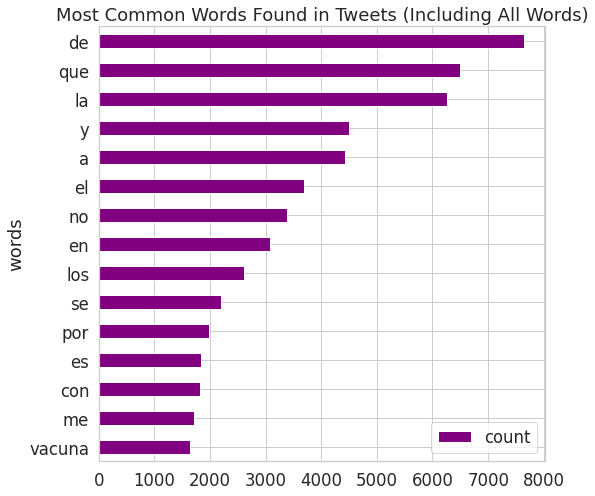

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
words_count.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Most Common Words Found in Tweets (Including All Words)")

plt.show()

### **Remover Stopwords**

Podemos ver en el gráfico de barras que las palabras con mayor frecuencia no son palabras relevantes, ya que no nos dan ninguna información significativa. Son las llamadas 'stop words' y por eso vamos a eliminarlas.

El paquete 'nltk' nos da una lista de stop words que utilizaremos para eliminar estas palabras vacías en nuestros tweets.


In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish')) # Set the language to Spanish

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Veamos algunos ejemplos de stop words:

In [ ]:
# View a few words from the set
list(stop_words)[0:20]

['otras',
 'ni',
 'estés',
 'siente',
 'fui',
 'somos',
 'había',
 'tú',
 'estarás',
 'habré',
 'tuvieras',
 'fuimos',
 'habrás',
 'mío',
 'sentidos',
 'otra',
 'sería',
 'suyas',
 'tendré',
 'de']

Como podemos ver, el paquete nltk nos ofrece un conjunto de palabras en español. Sin embargo, están claramente en español de España, esto podría llevarnos a un proceso de eliminación de stopwords menos eficiente.

Ahora vamos a imprimir de nuevo un tweet antes de eliminar las stopwords para hacer una comparación después del proceso.

In [ ]:
words_in_tweet[0]

['no',
 'dejen',
 'de',
 'mirar',
 'numero',
 'de',
 'casos',
 'positivos',
 'de',
 'ayer',
 'y',
 'numero',
 'en',
 'cti',
 '992',
 'y',
 '80']

In [ ]:
# Remove stop words from each tweet list of words
tweets_nsw = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in words_in_tweet]

tweets_nsw[0]

['dejen',
 'mirar',
 'numero',
 'casos',
 'positivos',
 'ayer',
 'numero',
 'cti',
 '992',
 '80']

Una vez que hemos eliminado las stopwords, está claro que la cantidad de palabras es considerablemente menor. Esto nos va a ayudar a realizar un análisis más significativo y eficaz. Ahora, vamos a contar las palabras de nuevo y a trazar un gráfico de barras de frecuencia.

In [ ]:
all_words_nsw = list(itertools.chain(*tweets_nsw))

counts_nsw = collections.Counter(all_words_nsw)

counts_nsw.most_common(15)

[('vacuna', 1643),
 ('si', 1196),
 ('vacunas', 980),
 ('mas', 844),
 ('vacunacion', 651),
 ('hoy', 584),
 ('vacunarse', 515),
 ('dosis', 499),
 ('q', 487),
 ('vacunar', 411),
 ('gente', 384),
 ('personas', 362),
 ('dia', 357),
 ('salud', 352),
 ('ser', 350)]

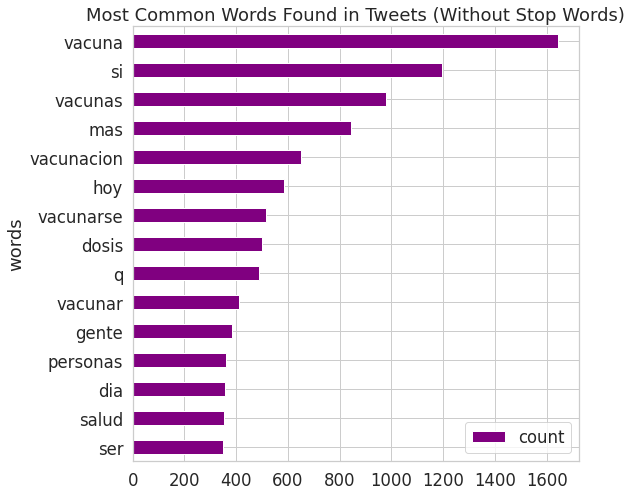

In [ ]:
words_count_nsw = pd.DataFrame(counts_nsw.most_common(15),
                             columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
words_count_nsw.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Most Common Words Found in Tweets (Without Stop Words)")

plt.show()

Así que ahora las palabras de mayor frecuencia parecen ser palabras "más relevantes" que las stop words.

### **Stemming / Lematización**

Tanto el stemming como la lematización generan la forma de la raíz de las palabras flexionadas. La diferencia es que la raíz puede no ser una palabra real, mientras que el lema es una palabra real del idioma.

Dado que la mayoría de los paquetes que existen para las tareas de PNL se centran en el inglés, puede resultar difícil realizar tareas como el stemming o la lematización. Sin embargo, hay un paquete llamado 'Stanza' que nos da herramientas para crear modelos de PNL en muchos idiomas.

Vamos a utilizar la lematización para que puedas ver cómo funciona.

In [ ]:
pip install stanza

In [ ]:
import stanza
stanza.download('es', package='ancora', processors='tokenize,mwt,pos,lemma', verbose=True)
stNLP = stanza.Pipeline(processors='tokenize,mwt,pos,lemma', lang='es', use_gpu=True)

2021-03-08 17:48:27 INFO: Downloading these customized packages for language: es (Spanish)...
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| pretrain  | ancora  |

2021-03-08 17:48:27 INFO: File exists: /root/stanza_resources/es/tokenize/ancora.pt.
2021-03-08 17:48:27 INFO: File exists: /root/stanza_resources/es/mwt/ancora.pt.
2021-03-08 17:48:27 INFO: File exists: /root/stanza_resources/es/pos/ancora.pt.
2021-03-08 17:48:27 INFO: File exists: /root/stanza_resources/es/lemma/ancora.pt.
2021-03-08 17:48:27 INFO: File exists: /root/stanza_resources/es/pretrain/ancora.pt.
2021-03-08 17:48:27 INFO: Finished downloading models and saved to /root/stanza_resources.
2021-03-08 17:48:27 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |

2021-03-08 17:

In [ ]:
def join_string(list_string): 
  
    # Join the string based on '-' delimiter 
    string = ' '.join(list_string) 
      
    return string 

In [ ]:
rejoined_tweets =  [' '.join(tweet) for tweet in tweets_nsw]
rejoined_tweets[6]
tweets["Texto"] = rejoined_tweets
tweets
tweets.to_csv('data/data_classifier/tweetsSINSTOPWORDS.csv')

In [ ]:
processed_tweets = [stNLP(tweet) for tweet in rejoined_tweets]

In [ ]:
lemmatized_tweets = []
for t in processed_tweets:
  lemmatized_tweets.append([word.lemma for sent in t.sentences for word in sent.words])

In [ ]:
lemmatized_tweets[6]

['hecho', 'junto', 'acabar']

In [ ]:
tweets_final =  [' '.join(tweet) for tweet in lemmatized_tweets]
tweets_final[6]

'hecho junto acabar'

In [ ]:
tweets["Texto"] = tweets_final
tweets

,Unnamed: 0,Unnamed: 0.1,Nombre de usuario,Usuario,Fecha,Texto,Sentimiento
0,0,0,Aurora Fuentes,@paysandusiempre,2021-03-06,dejar mirar numero caso positivo ayer numero c...,1
1,1,1,majo,@majoattacks,2021-03-06,adulto mayor familia tambien hacer conversar a...,1
2,2,2,#YoApruebo,@xapahernandez,2021-03-06,dalai lama vacuno todavia dar color,1
3,3,3,Ashishito\n#MascarillaBienPuesta,@jorgeapolaya,2021-03-06,terruqueo desinformacion willaxtv periodismo l...,1
4,4,4,Jose Ragas,@joseragas,2021-03-06,hacer willax libertad expresion campana delibe...,1
...,...,...,...,...,...,...,...
7659,7659,2622,lid,@ldutari,2020-11-04,loco aunque obligatorio decir gratis pagar,0
7660,7660,2623,Juan Manuel,@majud03,2020-11-04,familia metansar vacuna bien,0
7661,7661,2624,Florencia Balcarce,@beappatt,2020-11-04,vacuna swine flu 1976 ocasionar mas muerte enf...,0
7662,7662,2625,"No, Korruptos",@carlita_River19,2020-11-04,causa gracia xq grieta ahora vacuna unico dive...,0


Guardamos los tweets lematizados

In [ ]:
tweets.to_csv('data/data_classifier/tweetsCONLEMMA.csv')

## **Limpiar tweets para la validación del modelo clasificador**

Se realizará el mismo proceso anterior, solo que con el dataset d validación, con el fin de evaluar los modelos lematizados correctamente.

In [ ]:
tweets = pd.read_csv('data/data_classifier/tweets_validation.csv')
tweets_copia =  tweets['Texto'].values
tweets_copia

array(['Las vacunas matan gente y no lo están diciendo #YoNoMeVacuno',
       ' Aplicadores anales: La nueva forma del régimen chino para someter a su gente a la detección del virus PCCh\nUna nueva forma de tomar el test,  esta vez por el recto.\n\nExigimos que se lo claven primero a la izquierda comunista. #Covid\n#YoNoMeVacuno',
       'Me encanta que haya tanta gente diciendo #YoNoMeVacuno así para los que si queremos nos va a llegar más rápido',
       ...,
       'A pesar de haber sido los consentidos de la Nación, hoy Colombia produce menos carne vacuna que en 1990. A pesar de usar más área para ese fin, tan improductivos son que Uruguay tiene con 1/6 de nuestro tamaño casi la misma producción.',
       '¿Cuando va a llegar a Colombia la vacuna contra el Covid?Octubre\n0 %\nNoviembre\n12,5 %\nDiciembre\n6,3 %\n2021\n81,3 %\n16 votos\n·\nResultados finales',
       'Pues no se pero lo que entendí es que la vacuna en Colombia será para nuestros adultos mayores pero seremos parte de

### **Removing Punctuations and Special Characters**

In [ ]:
def normalize(s):
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
        ("ñ", "n"),
        (",",""),
        (".",""),
        (";",""),
        ("¿",""),
        ("?","")
    )
    for a, b in replacements:
        s = s.replace(a, b).replace(a.upper(), b.upper())
    return s

In [ ]:
for i in range(len(tweets_copia)):
  tweets_copia[i] = normalize(tweets_copia[i])
  tweets_copia[i] = tweets_copia[i].lower()
  p.set_options(p.OPT.URL, p.OPT.HASHTAG, p.OPT.EMOJI, p.OPT.MENTION)
  tweets_copia[i] = p.clean(tweets_copia[i])

tweets_copia

array(['las vacunas matan gente y no lo estan diciendo',
       'aplicadores anales: la nueva forma del regimen chino para someter a su gente a la deteccion del virus pcch una nueva forma de tomar el test esta vez por el recto exigimos que se lo claven primero a la izquierda comunista',
       'me encanta que haya tanta gente diciendo asi para los que si queremos nos va a llegar mas rapido',
       ...,
       'a pesar de haber sido los consentidos de la nacion hoy colombia produce menos carne vacuna que en 1990 a pesar de usar mas area para ese fin tan improductivos son que uruguay tiene con 1/6 de nuestro tamano casi la misma produccion',
       'cuando va a llegar a colombia la vacuna contra el covidoctubre 0 % noviembre 125 % diciembre 63 % 2021 813 % 16 votos resultados finales',
       'pues no se pero lo que entendi es que la vacuna en colombia sera para nuestros adultos mayores pero seremos parte de la fase experimental quieren cogerlos de conejillo de indias no hay derecho'],


In [ ]:
#@title **Cleanse Functions**

# Removes links and @ signs
def cleanText(txt):
  return re.sub('([^0-9A-Za-zñÑáéíóúÁÉÍÓÚ \t])|(\w+:\/\/\S+)', '', txt)

# Removes Punctuation including # signs and emojis
# def remove_punctuation(txt):
#   return re.sub(r'[^\w\s]', ' ', txt)

# Removes extra spaces
def remove_extra_spaces(txt):
  return re.sub(' +', ' ', txt)

In [ ]:
tweets_copia = np.array([cleanText(tweet) for tweet in tweets_copia])
tweets_copia[:20]

array(['las vacunas matan gente y no lo estan diciendo',
       'aplicadores anales la nueva forma del regimen chino para someter a su gente a la deteccion del virus pcch una nueva forma de tomar el test esta vez por el recto exigimos que se lo claven primero a la izquierda comunista',
       'me encanta que haya tanta gente diciendo asi para los que si queremos nos va a llegar mas rapido',
       'mejor asi los que nos queremos vacunar lo hacemos mas rapido ',
       'coman mierda hptas', 'disque como si los fueran a vacunar',
       'si una enfermedad viene viene para quedarse 2021 aun seguimos tratando el h1n1 existen protocolos de prevencion y nosotros como ciudadanos debemos cuidarnos y cuidar al resto esto no es cuarentena es un engano del gobierno para vacunarnos',
       'dicen porque creen que la vacuna modificara su adn aunque algunos de ustedes son tan estupidos que tal vez esa modificacion no sea tan mala idea',
       'porque el gobierno inepto de no supo negociar en ingle

In [ ]:
tweets["Texto"] = tweets_copia

In [ ]:
tweets.to_csv('data/data_classifier/tweets_validation_NOLEMMA.csv')
tweets

,Unnamed: 0,Nombre de usuario,Usuario,Fecha,Texto
0,0,Bautista Péntecost XY,@BautiPentecost,2021-01-27,las vacunas matan gente y no lo estan diciendo
1,1,Némesis,@MaryBol95533136,2021-01-27,aplicadores anales la nueva forma del regimen ...
2,2,S A N T I,@diluidoenagua,2021-01-27,me encanta que haya tanta gente diciendo asi p...
3,3,moon:),@luuunaaaaaaaae,2021-01-27,mejor asi los que nos queremos vacunar lo hace...
4,4,Carlos.,@Carloscdc06,2021-01-27,coman mierda hptas
...,...,...,...,...,...
14074,8508,Ells,@ellscms,2020-08-08,pregunta muy seria ustedes se pondrian la vacu...
14075,8509,J_Lozano.,@J_LozanoC,2020-08-08,cuando llegue la vacuna a colombia se imaginan...
14076,8510,Jair G. Camargo R.,@ingeniero0013,2020-08-08,a pesar de haber sido los consentidos de la na...
14077,8511,Paradise.,@_DreamWorlds_,2020-08-08,cuando va a llegar a colombia la vacuna contra...


### Split data

In [ ]:
words_in_tweet = [tweet.split() for tweet in tweets_copia]
words_in_tweet[0]

['las', 'vacunas', 'matan', 'gente', 'y', 'no', 'lo', 'estan', 'diciendo']

In [ ]:
# List of all words across tweets
all_words = list(itertools.chain(*words_in_tweet))

# Create counter
counts = collections.Counter(all_words)

counts.most_common(15) # Print 15 most common words

[('la', 17542),
 ('de', 16312),
 ('que', 14810),
 ('vacuna', 10392),
 ('en', 10281),
 ('a', 9883),
 ('y', 8707),
 ('el', 8614),
 ('colombia', 8292),
 ('no', 7478),
 ('los', 5776),
 ('se', 4660),
 ('para', 4311),
 ('es', 3783),
 ('por', 3498)]

In [ ]:
words_count = pd.DataFrame(counts.most_common(15),
                             columns=['words', 'count'])

words_count.head()

,words,count
0,la,17542
1,de,16312
2,que,14810
3,vacuna,10392
4,en,10281


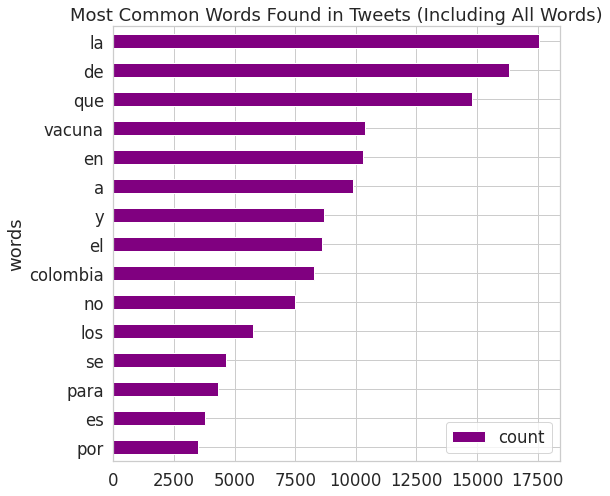

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
words_count.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Most Common Words Found in Tweets (Including All Words)")

plt.show()

### **Stopwords Removal**

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish')) # Set the language to Spanish

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# View a few words from the set
list(stop_words)[0:20]

['otras',
 'ni',
 'estés',
 'siente',
 'fui',
 'somos',
 'había',
 'tú',
 'estarás',
 'habré',
 'tuvieras',
 'fuimos',
 'habrás',
 'mío',
 'sentidos',
 'otra',
 'sería',
 'suyas',
 'tendré',
 'de']

In [ ]:
words_in_tweet[0]

['las', 'vacunas', 'matan', 'gente', 'y', 'no', 'lo', 'estan', 'diciendo']

In [ ]:
# Remove stop words from each tweet list of words
tweets_nsw = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in words_in_tweet]

tweets_nsw[0]

['vacunas', 'matan', 'gente', 'estan', 'diciendo']

In [ ]:
all_words_nsw = list(itertools.chain(*tweets_nsw))

counts_nsw = collections.Counter(all_words_nsw)

counts_nsw.most_common(15)

[('vacuna', 10392),
 ('colombia', 8292),
 ('si', 2502),
 ('mas', 1834),
 ('covid', 1245),
 ('vacunas', 1206),
 ('gobierno', 1023),
 ('pais', 947),
 ('covid19', 854),
 ('gente', 793),
 ('va', 772),
 ('rusa', 753),
 ('van', 725),
 ('q', 710),
 ('ser', 706)]

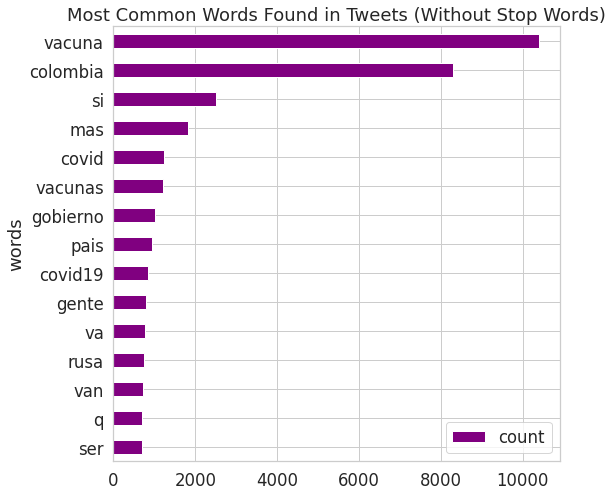

In [ ]:
words_count_nsw = pd.DataFrame(counts_nsw.most_common(15),
                             columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
words_count_nsw.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Most Common Words Found in Tweets (Without Stop Words)")

plt.show()

### **Stemming / Lemmatization**

In [ ]:
rejoined_tweets =  [' '.join(tweet) for tweet in tweets_nsw]
rejoined_tweets[6]
tweets["Texto"] = rejoined_tweets
tweets
tweets.to_csv('data/data_classifier/tweets_validationSINSTOPWORDS.csv')
tweets.shape

(14079, 5)

In [ ]:
processed_tweets = [stNLP(tweet) for tweet in rejoined_tweets]

In [ ]:
lemmatized_tweets = []
for t in processed_tweets:
  lemmatized_tweets.append([word.lemma for sent in t.sentences for word in sent.words])

In [ ]:
lemmatized_tweets[6]

['si',
 'enfermedad',
 'venir',
 'venir',
 'quedar',
 'él',
 '2021',
 'aun',
 'seguir',
 'tratar',
 'h1n1',
 'existir',
 'protocolo',
 'prevencion',
 'ciudadano',
 'deber',
 'cuidar',
 'yo',
 'cuidar',
 'resto',
 'cuarentena',
 'engano',
 'gobierno',
 'vacunarno']

In [ ]:
tweets_final =  [' '.join(tweet) for tweet in lemmatized_tweets]
tweets_final[6]

'si enfermedad venir venir quedar él 2021 aun seguir tratar h1n1 existir protocolo prevencion ciudadano deber cuidar yo cuidar resto cuarentena engano gobierno vacunarno'

In [ ]:
tweets["Texto"] = tweets_final
tweets

,Unnamed: 0,Nombre de usuario,Usuario,Fecha,Texto
0,0,Bautista Péntecost XY,@BautiPentecost,2021-01-27,vacuna matar gente estar decir
1,1,Némesis,@MaryBol95533136,2021-01-27,aplicador anales nuevo formar regimen chino so...
2,2,S A N T I,@diluidoenagua,2021-01-27,encantar tanto gente decir asi si querer ir ll...
3,3,moon:),@luuunaaaaaaaae,2021-01-27,mejor asi querer vacunar hacer mas rapido
4,4,Carlos.,@Carloscdc06,2021-01-27,comar mierda hpta
...,...,...,...,...,...
14074,8508,Ells,@ellscms,2020-08-08,pregunta serio tú poneriar vacuna covid si lle...
14075,8509,J_Lozano.,@J_LozanoC,2020-08-08,llegar vacuna colombio imaginar cartel covid19
14076,8510,Jair G. Camargo R.,@ingeniero0013,2020-08-08,pesar haber ser consentir nacion hoy colombia ...
14077,8511,Paradise.,@_DreamWorlds_,2020-08-08,ir llegar colombia vacuna covidoctubre 0 novie...


In [ ]:
tweets.to_csv('data/data_classifier/tweets_validationCONLEMMA.csv')

# **RNN MODELS**

Para el desarrollo e implementación de modelos, se propuso implementar tres arquitecturas diferentes: LSTM, LSTM Bidirectional, GRU. Cada arquitectura se enrenará con dos datasets diferentes, los cuales corresponden a los tweets sin lematizar y con stopwords, y a los tweets lematizados y sin stopwords.

## Modelos con stopwords y sin lematización

Leemos los datos

In [ ]:
tweets = pd.read_csv('data/data_classifier/tweets_process.csv')
tweets

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Nombre de usuario,Usuario,Fecha,Texto,Sentimiento
0,0,0,0,Aurora Fuentes,@paysandusiempre,2021-03-06,no dejen de mirar numero de casos positivos de...,1
1,1,1,1,majo,@majoattacks,2021-03-06,y todos los adultos mayores de mi familia tamb...,1
2,2,2,2,#YoApruebo,@xapahernandez,2021-03-06,hasta el dalai lama se vacuno y todavia alguno...,1
3,3,3,3,Ashishito\n#MascarillaBienPuesta,@jorgeapolaya,2021-03-06,contra el terruqueo contra la desinformacion d...,1
4,4,4,4,Jose Ragas,@joseragas,2021-03-06,lo que hace willax no es libertad de expresion...,1
...,...,...,...,...,...,...,...,...
7659,7659,7659,2622,lid,@ldutari,2020-11-04,ni loca aunque sea obligatoria? y ni digan que...,0
7660,7660,7660,2623,Juan Manuel,@majud03,2020-11-04,ni mi familia metanse la vacuna bien en el,0
7661,7661,7661,2624,Florencia Balcarce,@beappatt,2020-11-04,la vacuna del swine flu en 1976 ocasiono mas m...,0
7662,7662,7662,2625,"No, Korruptos",@carlita_River19,2020-11-04,me causa gracia xq todo es grieta ahora la vac...,0


Como se puede observar, existe un desbalance de clases, debido a la limitación de tweets negativos que se pudieron obtener.

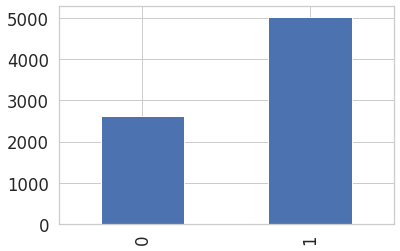

In [ ]:
tweets['Sentimiento'].value_counts().sort_index().plot.bar()

Obtenemos el número de carácteres por tweet

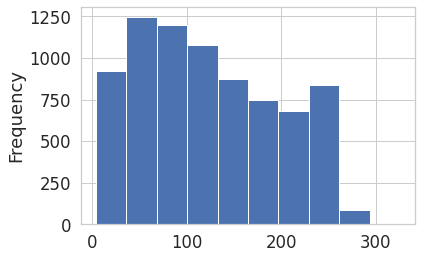

In [ ]:
tweets["Texto"].str.len().plot.hist() #Número de carácteres

### Primera arquitectura

En esta primera arquitectura, se plantean redes LSTM.

In [ ]:
tokenizer1 = Tokenizer(num_words=17104, split=" ") #Se vectorizan las palabras
tokenizer1.fit_on_texts(tweets["Texto"].values)

x1 = tokenizer1.texts_to_sequences(tweets["Texto"].values)
x1 = pad_sequences(x1)
print("Sin tokenizar: ", tweets["Texto"][0], "\n Tokenizado: \n", x1[0])
y1 = tweets['Sentimiento'].values
x1train, x1test, y1train, y1test = train_test_split(x1, y1, test_size = 0.3)

Sin tokenizar:  no dejen de mirar numero de casos positivos de ayer y numero en cti 992 y 80 
 Tokenizado: 
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    7  345    1 2197  699    1  306 1766    1  196    4  699
    8 1767 7332    4  553]


In [ ]:
model1 = tf.keras.models.Sequential()
model1.add(tf.keras.layers.Embedding(input_dim=17104, output_dim=512, input_length=x1.shape[1]))
model1.add(tf.keras.layers.Dropout(0.2))
model1.add(tf.keras.layers.LSTM(512, activation='tanh', return_sequences=True))
model1.add(tf.keras.layers.LSTM(512, activation='tanh', return_sequences=True))
model1.add(tf.keras.layers.LSTM(512, activation='tanh', return_sequences=True))#, dropout=0.3, recurrent_dropout=0.3))
#, dropout=0.3, recurrent_dropout=0.2))
model1.add(tf.keras.layers.GlobalMaxPooling1D())
model1.add(tf.keras.layers.Dense(64, activation='relu'))
model1.add(tf.keras.layers.Dense(32, activation='relu'))
model1.add(tf.keras.layers.Dropout(0.2))
model1.add(tf.keras.layers.Dense(16, activation='relu'))
model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 61, 512)           8757248   
_________________________________________________________________
dropout (Dropout)            (None, 61, 512)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 61, 512)           2099200   
_________________________________________________________________
lstm_1 (LSTM)                (None, 61, 512)           2099200   
_________________________________________________________________
lstm_2 (LSTM)                (None, 61, 512)           2099200   
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model1.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])

In [ ]:
batch_size = 32
epochs = 100

#Callbacks

#ReduceLROnPlateau = tf.keras.callbacks.ReduceLROnPlateau( #Sirve para reducir el Learning Rate dados ciertos parametros
#    monitor = 'val_loss',  #Monitorea el val_loss
#    factor = 0.1, #Es el factor para bajar el lr, es decir, new_lr = factor*lr
#    min_delta = 0.001, #Valor para que se considere que hubo una mejora
#    patience = 3, #Número de épocas si no hay cambios para que el lr disminuya
#    verbose = 0,
#    mode = 'auto', 
#    min_lr = 0.00001, #Learning rate mínimo
#    cooldown = 4 #Número de epochs sin monitorear luego de aplicar un nuevo learning rate
#)

EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', #Se monitorea el val_loss
    min_delta = 0.001, #Número que se considera como un cambio significativo
    patience = 7, #Número de epochs sin cambios para detenerse
)
tf.keras.backend.clear_session()
history1 = model1.fit(x1train, y1train, validation_data=(x1test, y1test), callbacks=[EarlyStop],epochs = epochs, batch_size=batch_size)

Epoch 1/100
168/168 [==============================] - 46s 241ms/step - loss: 0.6534 - accuracy: 0.6644 - val_loss: 0.6409 - val_accuracy: 0.6578
Epoch 2/100
168/168 [==============================] - 38s 227ms/step - loss: 0.6130 - accuracy: 0.6614 - val_loss: 0.5334 - val_accuracy: 0.6991
Epoch 3/100
168/168 [==============================] - 37s 221ms/step - loss: 0.4376 - accuracy: 0.7863 - val_loss: 0.4918 - val_accuracy: 0.7465
Epoch 4/100
168/168 [==============================] - 35s 211ms/step - loss: 0.3029 - accuracy: 0.8723 - val_loss: 0.5247 - val_accuracy: 0.7674
Epoch 5/100
168/168 [==============================] - 35s 208ms/step - loss: 0.1976 - accuracy: 0.9207 - val_loss: 0.5663 - val_accuracy: 0.7626
Epoch 6/100
168/168 [==============================] - 37s 222ms/step - loss: 0.1458 - accuracy: 0.9403 - val_loss: 0.5994 - val_accuracy: 0.7691
Epoch 7/100
168/168 [==============================] - 37s 220ms/step - loss: 0.1066 - accuracy: 0.9615 - val_loss: 0.7275 -

In [ ]:
name_model = 'modelGlobalMaxPooling1D17104'
model1.save('models/'+name_model+'.h5')

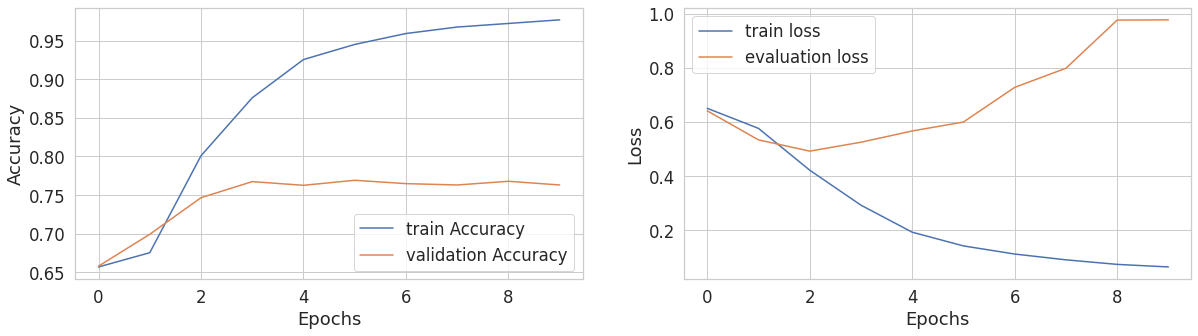

In [ ]:
#@title **code**. To show prediction for a specific image
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history1.history['accuracy'], label='train Accuracy');
ax.plot(history1.history['val_accuracy'], label='validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history1.history['loss'], label='train loss');
ax.plot(history1.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


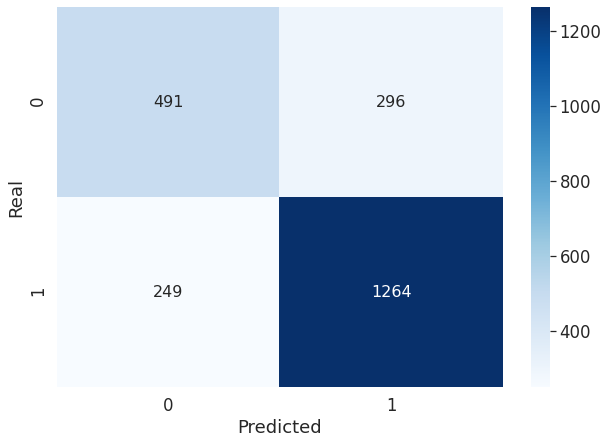

              precision    recall  f1-score   support

           0       0.66      0.62      0.64       787
           1       0.81      0.84      0.82      1513

    accuracy                           0.76      2300
   macro avg       0.74      0.73      0.73      2300
weighted avg       0.76      0.76      0.76      2300



In [ ]:
pred1 = model1.predict_classes(x1test)
y1_real = y1test
conf_mx = confusion_matrix(y1_real, pred1)
conf_mx

heat_cm = pd.DataFrame(conf_mx, columns=np.unique(y1_real), index = np.unique(y1_real))
heat_cm.index.name = 'Real'
heat_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.heatmap(heat_cm, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g')# font size
plt.show()
print(metrics.classification_report(y1_real,pred1))

#### Test the model

In [ ]:
modeloLSTM1 = tf.keras.models.load_model('models/modelGlobalMaxPooling1D17104.h5')
tweets_validation1 = pd.read_csv('data/data_classifier/tweets_validation_NOLEMMA.csv')
x1validation = tokenizer1.texts_to_sequences(tweets_validation1["Texto"].values)
x1validation = pad_sequences(x1validation, maxlen=61)
predicciones1 = modeloLSTM1.predict(x1validation)
predicciones1

array([[0.1570137 ],
       [0.00139277],
       [0.99990654],
       ...,
       [0.9999454 ],
       [0.99950635],
       [0.9995528 ]], dtype=float32)

In [ ]:
round_predicciones1 = []
for i in range(len(predicciones1)):
  if predicciones1[i]<0.5:
    round_predicciones1.append(0)
  else:
    round_predicciones1.append(1)

tweets_validation1["Sentimiento"] = round_predicciones1
tweets_validation1.to_csv('data/data_classifier/resultados/tweets_validation_modelGlobalMaxPooling1D.csv')
tweets_validation1

,Unnamed: 0,Unnamed: 0.1,Nombre de usuario,Usuario,Fecha,Texto,Sentimiento
0,0,0,Bautista Péntecost XY,@BautiPentecost,2021-01-27,las vacunas matan gente y no lo estan diciendo,0
1,1,1,Némesis,@MaryBol95533136,2021-01-27,aplicadores anales la nueva forma del regimen ...,0
2,2,2,S A N T I,@diluidoenagua,2021-01-27,me encanta que haya tanta gente diciendo asi p...,1
3,3,3,moon:),@luuunaaaaaaaae,2021-01-27,mejor asi los que nos queremos vacunar lo hace...,1
4,4,4,Carlos.,@Carloscdc06,2021-01-27,coman mierda hptas,0
...,...,...,...,...,...,...,...
14074,14074,8508,Ells,@ellscms,2020-08-08,pregunta muy seria ustedes se pondrian la vacu...,0
14075,14075,8509,J_Lozano.,@J_LozanoC,2020-08-08,cuando llegue la vacuna a colombia se imaginan...,1
14076,14076,8510,Jair G. Camargo R.,@ingeniero0013,2020-08-08,a pesar de haber sido los consentidos de la na...,1
14077,14077,8511,Paradise.,@_DreamWorlds_,2020-08-08,cuando va a llegar a colombia la vacuna contra...,1


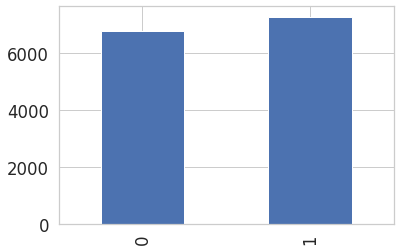

In [ ]:
tweets_validation1['Sentimiento'].value_counts().sort_index().plot.bar()

### Segunda arquitectura

En la segunda arquitectura, se proponen las mismas redes LSTM, agregando capas bidireccionales.

In [ ]:
tokenizer2 = Tokenizer(num_words=17104, split=" ")
tokenizer2.fit_on_texts(tweets["Texto"].values)

x2 = tokenizer2.texts_to_sequences(tweets["Texto"].values)
x2 = pad_sequences(x2)
print("Sin tokenizar: ", tweets["Texto"][0], "\n Tokenizado: \n", x2[0])
y2 = tweets['Sentimiento'].values
x2train, x2test, y2train, y2test = train_test_split(x2, y2, test_size = 0.3)

Sin tokenizar:  no dejen de mirar numero de casos positivos de ayer y numero en cti 992 y 80 
 Tokenizado: 
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    7  345    1 2197  699    1  306 1766    1  196    4  699
    8 1767 7332    4  553]


In [ ]:
model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.Embedding(input_dim=17104, output_dim=256, input_length=x2.shape[1]))
model2.add(tf.keras.layers.SpatialDropout1D(0.2))
model2.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, activation='tanh', return_sequences=True)))#, dropout=0.3, recurrent_dropout=0.3))
model2.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation='tanh', return_sequences=True)))##, dropout=0.3, recurrent_dropout=0.3))
model2.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh')))##, dropout=0.3, recurrent_dropout=0.2))
model2.add(tf.keras.layers.Dense(64, activation='relu'))
model2.add(tf.keras.layers.Dense(32, activation='relu'))
model2.add(tf.keras.layers.Dropout(0.5))
model2.add(tf.keras.layers.Dense(16, activation='relu'))
model2.add(tf.keras.layers.Dropout(0.5))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 61, 256)           4378624   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 61, 256)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 61, 512)           1050624   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 61, 256)           656384    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])
batch_size = 32
epochs = 100

#Callbacks

EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', #Se monitorea el val_loss
    min_delta = 0.001, #Número que se considera como un cambio significativo
    patience = 7, #Número de epochs sin cambios para detenerse
)
tf.keras.backend.clear_session()
history2 = model2.fit(x2train, y2train, validation_data=(x2test, y2test) ,callbacks=[EarlyStop] ,epochs = epochs, batch_size=batch_size)

Epoch 1/100
168/168 [==============================] - 45s 206ms/step - loss: 0.6540 - accuracy: 0.6401 - val_loss: 0.6435 - val_accuracy: 0.6696
Epoch 2/100
168/168 [==============================] - 32s 192ms/step - loss: 0.5069 - accuracy: 0.7730 - val_loss: 0.4667 - val_accuracy: 0.7613
Epoch 3/100
168/168 [==============================] - 32s 192ms/step - loss: 0.3004 - accuracy: 0.8928 - val_loss: 0.4445 - val_accuracy: 0.7961
Epoch 4/100
168/168 [==============================] - 32s 192ms/step - loss: 0.1752 - accuracy: 0.9591 - val_loss: 0.6700 - val_accuracy: 0.7935
Epoch 5/100
168/168 [==============================] - 32s 192ms/step - loss: 0.1155 - accuracy: 0.9724 - val_loss: 0.9196 - val_accuracy: 0.7783
Epoch 6/100
168/168 [==============================] - 32s 191ms/step - loss: 0.0762 - accuracy: 0.9803 - val_loss: 0.9901 - val_accuracy: 0.7874
Epoch 7/100
168/168 [==============================] - 32s 192ms/step - loss: 0.0512 - accuracy: 0.9868 - val_loss: 1.2769 -

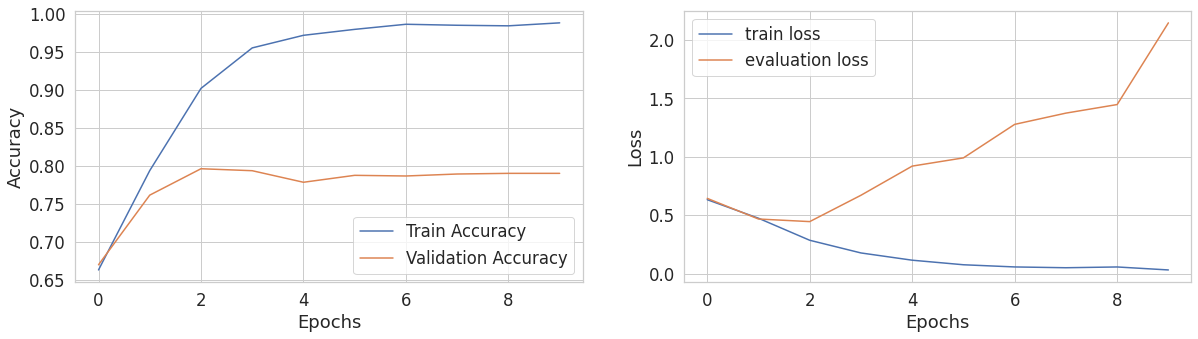

In [ ]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history2.history['accuracy'], label='Train Accuracy');
ax.plot(history2.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history2.history['loss'], label='train loss');
ax.plot(history2.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


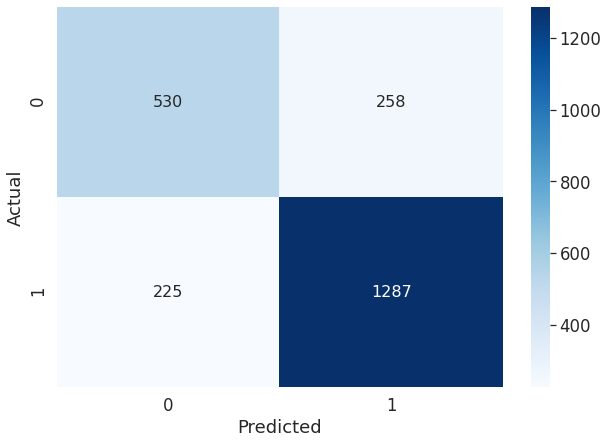

              precision    recall  f1-score   support

           0       0.70      0.67      0.69       788
           1       0.83      0.85      0.84      1512

    accuracy                           0.79      2300
   macro avg       0.77      0.76      0.76      2300
weighted avg       0.79      0.79      0.79      2300



In [ ]:
pred2 = model2.predict_classes(x2test)
y2_real = y2test
conf_mx = confusion_matrix(y2_real, pred2)
conf_mx

heat_cm = pd.DataFrame(conf_mx, columns=np.unique(y2_real), index = np.unique(y2_real))
heat_cm.index.name = 'Actual'
heat_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.heatmap(heat_cm, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g')# font size
plt.show()
print(metrics.classification_report(y2_real,pred2))

In [ ]:
name_model = 'modelBidirectional1704'
model2.save('models/'+name_model+'.h5')

#### Test the model

In [ ]:
modeloLSTM2 = tf.keras.models.load_model('models/modelBidirectional1704.h5')
tweets_validation2 = pd.read_csv('data/data_classifier/tweets_validation_NOLEMMA.csv')
x2_validation = tokenizer.texts_to_sequences(tweets_validation2["Texto"].values)
x2_validation = pad_sequences(x2_validation, maxlen=61)
predicciones2 = modeloLSTM2.predict(x2_validation)
predicciones2

array([[4.0037280e-01],
       [4.9998378e-04],
       [1.0000000e+00],
       ...,
       [1.0000000e+00],
       [3.9060614e-01],
       [1.0000000e+00]], dtype=float32)

In [ ]:
round_predicciones2 = []
for i in range(len(predicciones2)):
  if predicciones2[i]<0.5:
    round_predicciones2.append(0)
  else:
    round_predicciones2.append(1)

tweets_validation2["Sentimiento"] = round_predicciones2
tweets_validation2.to_csv('data/data_classifier/resultados/tweets_validation_modelBidirectional17104.csv')
tweets_validation2

,Unnamed: 0,Unnamed: 0.1,Nombre de usuario,Usuario,Fecha,Texto,Sentimiento
0,0,0,Bautista Péntecost XY,@BautiPentecost,2021-01-27,las vacunas matan gente y no lo estan diciendo,0
1,1,1,Némesis,@MaryBol95533136,2021-01-27,aplicadores anales la nueva forma del regimen ...,0
2,2,2,S A N T I,@diluidoenagua,2021-01-27,me encanta que haya tanta gente diciendo asi p...,1
3,3,3,moon:),@luuunaaaaaaaae,2021-01-27,mejor asi los que nos queremos vacunar lo hace...,1
4,4,4,Carlos.,@Carloscdc06,2021-01-27,coman mierda hptas,0
...,...,...,...,...,...,...,...
14074,14074,8508,Ells,@ellscms,2020-08-08,pregunta muy seria ustedes se pondrian la vacu...,0
14075,14075,8509,J_Lozano.,@J_LozanoC,2020-08-08,cuando llegue la vacuna a colombia se imaginan...,0
14076,14076,8510,Jair G. Camargo R.,@ingeniero0013,2020-08-08,a pesar de haber sido los consentidos de la na...,1
14077,14077,8511,Paradise.,@_DreamWorlds_,2020-08-08,cuando va a llegar a colombia la vacuna contra...,0


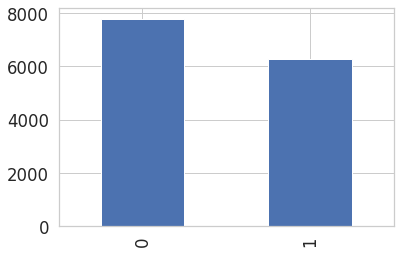

In [ ]:
tweets_validation2['Sentimiento'].value_counts().sort_index().plot.bar()

### Tercera arquitectura

Para esta última arquitectura, se emplean capas GRU Bidireccionales

In [ ]:
tokenizer = Tokenizer(num_words=17104, split=" ")
tokenizer.fit_on_texts(tweets["Texto"].values)

x3 = tokenizer.texts_to_sequences(tweets["Texto"].values)
x3 = pad_sequences(x3)
print("Sin tokenizar: ", tweets["Texto"][0], "\n Tokenizado: \n", x3[0])
y3 = tweets['Sentimiento'].values
x3train, x3test, y3train, y3test = train_test_split(x3, y3, test_size = 0.3)

Sin tokenizar:  no dejen de mirar numero de casos positivos de ayer y numero en cti 992 y 80 
 Tokenizado: 
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    7  345    1 2197  699    1  306 1766    1  196    4  699
    8 1767 7332    4  553]


In [ ]:
model3 = tf.keras.models.Sequential()
model3.add(tf.keras.layers.Embedding(input_dim=17104, output_dim=256, input_length=x3.shape[1]))
model3.add(tf.keras.layers.SpatialDropout1D(0.2))
model3.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, activation='tanh', return_sequences=True)))
model3.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, activation='tanh', return_sequences=True)))##, dropout=0.3, recurrent_dropout=0.3))
model3.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, activation='tanh',return_sequences=True)))
model3.add(tf.keras.layers.GlobalMaxPooling1D())
model3.add(tf.keras.layers.Dense(256, activation='relu'))
model3.add(tf.keras.layers.Dense(32, activation='relu'))
model3.add(tf.keras.layers.Dropout(0.5))
model3.add(tf.keras.layers.Dense(16, activation='relu'))
model3.add(tf.keras.layers.Dropout(0.5))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 61, 256)           4378624   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 61, 256)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 61, 512)           789504    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 61, 256)           493056    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 61, 128)           123648    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               3

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model3.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])

In [ ]:
batch_size = 32
epochs = 100

#Callbacks

EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', #Se monitorea el val_loss
    min_delta = 0.001, #Número que se considera como un cambio significativo
    patience = 10, #Número de epochs sin cambios para detenerse
)
tf.keras.backend.clear_session()
history3 = model3.fit(x3train, y3train, validation_data=(x3test, y3test) ,callbacks=[EarlyStop] ,epochs = epochs, batch_size=batch_size)

Epoch 1/100
168/168 [==============================] - 42s 188ms/step - loss: 0.6436 - accuracy: 0.6374 - val_loss: 0.4604 - val_accuracy: 0.7687
Epoch 2/100
168/168 [==============================] - 30s 176ms/step - loss: 0.4341 - accuracy: 0.7837 - val_loss: 0.4604 - val_accuracy: 0.7852
Epoch 3/100
168/168 [==============================] - 29s 175ms/step - loss: 0.2414 - accuracy: 0.9102 - val_loss: 0.5269 - val_accuracy: 0.7743
Epoch 4/100
168/168 [==============================] - 30s 176ms/step - loss: 0.1368 - accuracy: 0.9511 - val_loss: 0.6815 - val_accuracy: 0.7848
Epoch 5/100
168/168 [==============================] - 30s 177ms/step - loss: 0.0987 - accuracy: 0.9705 - val_loss: 0.7889 - val_accuracy: 0.7774
Epoch 6/100
168/168 [==============================] - 30s 176ms/step - loss: 0.0652 - accuracy: 0.9740 - val_loss: 0.9095 - val_accuracy: 0.7861
Epoch 7/100
168/168 [==============================] - 30s 176ms/step - loss: 0.0806 - accuracy: 0.9762 - val_loss: 1.3170 -

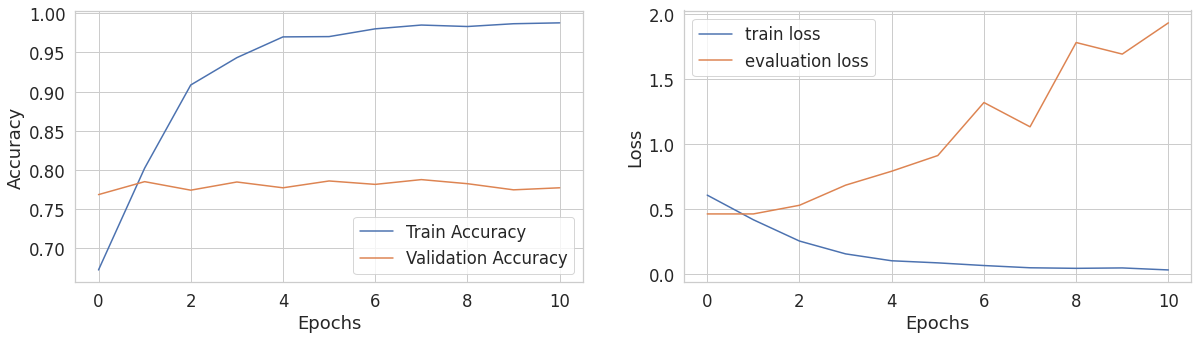

In [ ]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history3.history['accuracy'], label='Train Accuracy');
ax.plot(history3.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history3.history['loss'], label='train loss');
ax.plot(history3.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


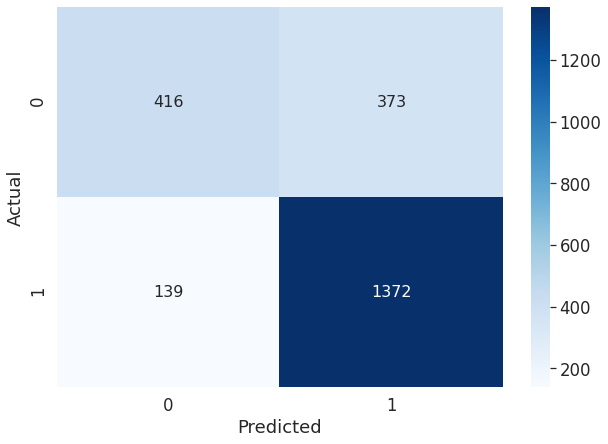

              precision    recall  f1-score   support

           0       0.75      0.53      0.62       789
           1       0.79      0.91      0.84      1511

    accuracy                           0.78      2300
   macro avg       0.77      0.72      0.73      2300
weighted avg       0.77      0.78      0.77      2300



In [ ]:
pred3 = model3.predict_classes(x3test)
y3_real = y3test
conf_mx = confusion_matrix(y3_real, pred3)
conf_mx

heat_cm = pd.DataFrame(conf_mx, columns=np.unique(y2_real), index = np.unique(y3_real))
heat_cm.index.name = 'Actual'
heat_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.heatmap(heat_cm, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g')# font size
plt.show()
print(metrics.classification_report(y3_real,pred3))

In [ ]:
name_model = 'modelBidirectionalAndMax17104'
model3.save('models/'+name_model+'.h5')

#### Test the model

In [ ]:
modeloLSTM3 = tf.keras.models.load_model('models/modelBidirectionalAndMax17104.h5')
tweets_validation3 = pd.read_csv('data/data_classifier/tweets_validation_NOLEMMA.csv')
x3 = tokenizer.texts_to_sequences(tweets_validation3["Texto"].values)
x3 = pad_sequences(x3, maxlen=61)
predicciones3 = modeloLSTM3.predict(x3)
predicciones3

array([[0.88226783],
       [0.116445  ],
       [0.99964595],
       ...,
       [0.9997228 ],
       [0.9965829 ],
       [0.04772437]], dtype=float32)

In [ ]:
round_predicciones3 = []
for i in range(len(predicciones3)):
  if predicciones3[i]<0.5:
    round_predicciones3.append(0)
  else:
    round_predicciones3.append(1)

tweets_validation3["Sentimiento"] = round_predicciones3
tweets_validation3.to_csv('data/data_classifier/resultados/tweets_validation_modelBidirectionalAndMax1704.csv')
tweets_validation3

,Unnamed: 0,Unnamed: 0.1,Nombre de usuario,Usuario,Fecha,Texto,Sentimiento
0,0,0,Bautista Péntecost XY,@BautiPentecost,2021-01-27,las vacunas matan gente y no lo estan diciendo,1
1,1,1,Némesis,@MaryBol95533136,2021-01-27,aplicadores anales la nueva forma del regimen ...,0
2,2,2,S A N T I,@diluidoenagua,2021-01-27,me encanta que haya tanta gente diciendo asi p...,1
3,3,3,moon:),@luuunaaaaaaaae,2021-01-27,mejor asi los que nos queremos vacunar lo hace...,0
4,4,4,Carlos.,@Carloscdc06,2021-01-27,coman mierda hptas,0
...,...,...,...,...,...,...,...
14074,14074,8508,Ells,@ellscms,2020-08-08,pregunta muy seria ustedes se pondrian la vacu...,1
14075,14075,8509,J_Lozano.,@J_LozanoC,2020-08-08,cuando llegue la vacuna a colombia se imaginan...,1
14076,14076,8510,Jair G. Camargo R.,@ingeniero0013,2020-08-08,a pesar de haber sido los consentidos de la na...,1
14077,14077,8511,Paradise.,@_DreamWorlds_,2020-08-08,cuando va a llegar a colombia la vacuna contra...,1


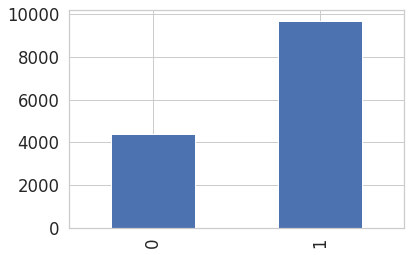

In [ ]:
tweets_validation3['Sentimiento'].value_counts().sort_index().plot.bar()

## Modelos sin stoptwords y con lematización

Ahora, se emplearan las mismas arquitecturas implementadas anteriormente, con la diferencia de que se entrenarán con un dataset de tweets lematizados y sin stopwords.

In [12]:
tweets = pd.read_csv('data/data_classifier/tweetsCONLEMMA.csv')
tweets

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Nombre de usuario,Usuario,Fecha,Texto,Sentimiento
0,0,0,0,Aurora Fuentes,@paysandusiempre,2021-03-06,dejar mirar numero caso positivo ayer numero c...,1
1,1,1,1,majo,@majoattacks,2021-03-06,adulto mayor familia tambien hacer conversar a...,1
2,2,2,2,#YoApruebo,@xapahernandez,2021-03-06,dalai lama vacuno todavia dar color,1
3,3,3,3,Ashishito\n#MascarillaBienPuesta,@jorgeapolaya,2021-03-06,terruqueo desinformacion willaxtv periodismo l...,1
4,4,4,4,Jose Ragas,@joseragas,2021-03-06,hacer willax libertad expresion campana delibe...,1
...,...,...,...,...,...,...,...,...
7659,7659,7659,2622,lid,@ldutari,2020-11-04,loco aunque obligatorio decir gratis pagar,0
7660,7660,7660,2623,Juan Manuel,@majud03,2020-11-04,familia metansar vacuna bien,0
7661,7661,7661,2624,Florencia Balcarce,@beappatt,2020-11-04,vacuna swine flu 1976 ocasionar mas muerte enf...,0
7662,7662,7662,2625,"No, Korruptos",@carlita_River19,2020-11-04,causa gracia xq grieta ahora vacuna unico dive...,0


In [13]:
def to_str(s):
  s = str(s)
  return s

In [14]:
tweets["Texto"] = tweets["Texto"].apply(to_str)
tweets

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Nombre de usuario,Usuario,Fecha,Texto,Sentimiento
0,0,0,0,Aurora Fuentes,@paysandusiempre,2021-03-06,dejar mirar numero caso positivo ayer numero c...,1
1,1,1,1,majo,@majoattacks,2021-03-06,adulto mayor familia tambien hacer conversar a...,1
2,2,2,2,#YoApruebo,@xapahernandez,2021-03-06,dalai lama vacuno todavia dar color,1
3,3,3,3,Ashishito\n#MascarillaBienPuesta,@jorgeapolaya,2021-03-06,terruqueo desinformacion willaxtv periodismo l...,1
4,4,4,4,Jose Ragas,@joseragas,2021-03-06,hacer willax libertad expresion campana delibe...,1
...,...,...,...,...,...,...,...,...
7659,7659,7659,2622,lid,@ldutari,2020-11-04,loco aunque obligatorio decir gratis pagar,0
7660,7660,7660,2623,Juan Manuel,@majud03,2020-11-04,familia metansar vacuna bien,0
7661,7661,7661,2624,Florencia Balcarce,@beappatt,2020-11-04,vacuna swine flu 1976 ocasionar mas muerte enf...,0
7662,7662,7662,2625,"No, Korruptos",@carlita_River19,2020-11-04,causa gracia xq grieta ahora vacuna unico dive...,0


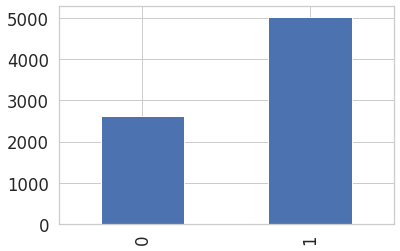

In [15]:
tweets['Sentimiento'].value_counts().sort_index().plot.bar()

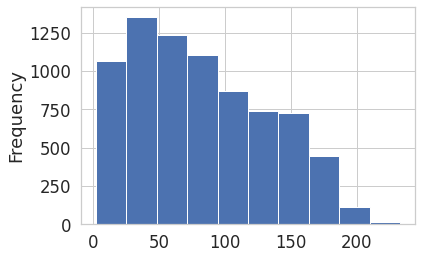

In [16]:
tweets["Texto"].str.len().plot.hist() #Número de carácteres

### Primera arquitectura

In [17]:
tokenizer1_1 = Tokenizer(num_words=12505, split=" ")
tokenizer1_1.fit_on_texts(tweets["Texto"].values)

x1_lem = tokenizer1_1.texts_to_sequences(tweets["Texto"].values)
x1_lem = pad_sequences(x1_lem)
print("Sin tokenizar: ", tweets["Texto"][0], "\n Tokenizado: \n", x1_lem[0])
y1_lem = tweets['Sentimiento'].values
x1lemtrain, x1lemtest, y1lemtrain, y1lemtest = train_test_split(x1_lem, y1_lem, test_size = 0.3)

Sin tokenizar:  dejar mirar numero caso positivo ayer numero cti 992 80 
 Tokenizado: 
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0   48  299  484
  106  454  138  484 1403 5279  514]


In [ ]:
model1_1 = tf.keras.models.Sequential()
model1_1.add(tf.keras.layers.Embedding(input_dim=12505, output_dim=256, input_length=x1_lem.shape[1]))
model1_1.add(tf.keras.layers.Dropout(0.2))
model1_1.add(tf.keras.layers.LSTM(256, activation='tanh', return_sequences=True))#, dropout=0.3, recurrent_dropout=0.3))
model1_1.add(tf.keras.layers.LSTM(256, activation='tanh', return_sequences=True))#, dropout=0.3, recurrent_dropout=0.3))
model1_1.add(tf.keras.layers.LSTM(256, activation='tanh', return_sequences=True))#, dropout=0.3, recurrent_dropout=0.2))
model1_1.add(tf.keras.layers.LSTM(256, activation='tanh', return_sequences=True))#, dropout=0.3, recurrent_dropout=0.2))
model1_1.add(tf.keras.layers.GlobalMaxPooling1D())
model1_1.add(tf.keras.layers.Dense(64, activation='relu'))
model1_1.add(tf.keras.layers.Dense(32, activation='relu'))
model1_1.add(tf.keras.layers.Dropout(0.2))
model1_1.add(tf.keras.layers.Dense(16, activation='relu'))
model1_1.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model1_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 35, 256)           3201280   
_________________________________________________________________
dropout (Dropout)            (None, 35, 256)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 35, 256)           525312    
_________________________________________________________________
lstm_1 (LSTM)                (None, 35, 256)           525312    
_________________________________________________________________
lstm_2 (LSTM)                (None, 35, 256)           525312    
_________________________________________________________________
lstm_3 (LSTM)                (None, 35, 256)           525312    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model1_1.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])

In [ ]:
batch_size = 32
epochs = 100

#Callbacks

#ReduceLROnPlateau = tf.keras.callbacks.ReduceLROnPlateau( #Sirve para reducir el Learning Rate dados ciertos parametros
#    monitor = 'val_loss',  #Monitorea el val_loss
#    factor = 0.1, #Es el factor para bajar el lr, es decir, new_lr = factor*lr
#    min_delta = 0.001, #Valor para que se considere que hubo una mejora
#    patience = 3, #Número de épocas si no hay cambios para que el lr disminuya
#    verbose = 0,
#    mode = 'auto', 
#    min_lr = 0.00001, #Learning rate mínimo
#    cooldown = 4 #Número de epochs sin monitorear luego de aplicar un nuevo learning rate
#)

EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', #Se monitorea el val_loss
    min_delta = 0.001, #Número que se considera como un cambio significativo
    patience = 20, #Número de epochs sin cambios para detenerse
)
tf.keras.backend.clear_session()
history1_1 = model1_1.fit(x1lemtrain, y1lemtrain, validation_data=(x1lemtest, y1lemtest), callbacks=[EarlyStop],epochs = epochs, batch_size=batch_size)

Epoch 1/100
168/168 [==============================] - 26s 119ms/step - loss: 0.6619 - accuracy: 0.6603 - val_loss: 0.6472 - val_accuracy: 0.6526
Epoch 2/100
168/168 [==============================] - 18s 109ms/step - loss: 0.6446 - accuracy: 0.6545 - val_loss: 0.6418 - val_accuracy: 0.6526
Epoch 3/100
168/168 [==============================] - 17s 103ms/step - loss: 0.5972 - accuracy: 0.6598 - val_loss: 0.5241 - val_accuracy: 0.7317
Epoch 4/100
168/168 [==============================] - 17s 101ms/step - loss: 0.4492 - accuracy: 0.7826 - val_loss: 0.4927 - val_accuracy: 0.7457
Epoch 5/100
168/168 [==============================] - 18s 108ms/step - loss: 0.3263 - accuracy: 0.8547 - val_loss: 0.5432 - val_accuracy: 0.7665
Epoch 6/100
168/168 [==============================] - 17s 102ms/step - loss: 0.2392 - accuracy: 0.8961 - val_loss: 0.5251 - val_accuracy: 0.7704
Epoch 7/100
168/168 [==============================] - 18s 105ms/step - loss: 0.1915 - accuracy: 0.9187 - val_loss: 0.5870 -

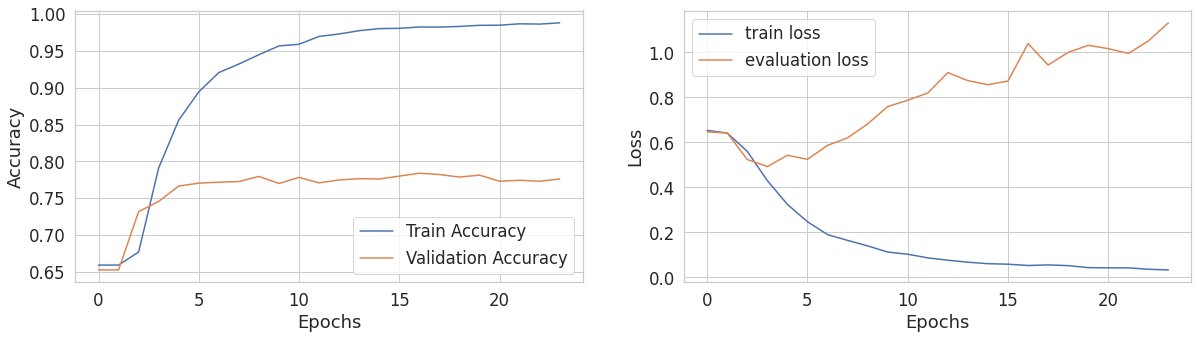

In [ ]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history1_1.history['accuracy'], label='Train Accuracy');
ax.plot(history1_1.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history1_1.history['loss'], label='train loss');
ax.plot(history1_1.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


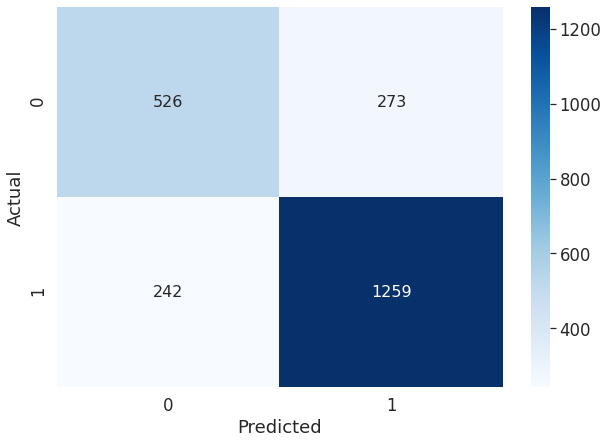

              precision    recall  f1-score   support

           0       0.68      0.66      0.67       799
           1       0.82      0.84      0.83      1501

    accuracy                           0.78      2300
   macro avg       0.75      0.75      0.75      2300
weighted avg       0.77      0.78      0.78      2300



In [ ]:
pred1_1 = model1_1.predict_classes(x1lemtest)
y1_1real = y1lemtest
conf_mx = confusion_matrix(y1_1real, pred1_1)
conf_mx

heat_cm = pd.DataFrame(conf_mx, columns=np.unique(y1_1real), index = np.unique(y1_1real))
heat_cm.index.name = 'Actual'
heat_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.heatmap(heat_cm, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g')# font size
plt.show()
print(metrics.classification_report(y1_1real,pred1_1))

In [ ]:
name_model = 'modelGlobalMaxPooling1DLEM12505'
model1_1.save('models/'+name_model+'.h5')

#### Test the model

In [18]:
modeloLSTM1_1 = tf.keras.models.load_model('models/modelGlobalMaxPooling1DLEM12505.h5')
tweets_validation1_1 = pd.read_csv('data/data_classifier/tweets_validationCONLEMMA.csv')
tweets_validation1_1["Texto"] = tweets_validation1_1["Texto"].apply(to_str)
x1_1validation = tokenizer1_1.texts_to_sequences(tweets_validation1_1["Texto"].values)
x1_1validation = pad_sequences(x1_1validation, maxlen=35)
predicciones1_1 = modeloLSTM1_1.predict(x1_1validation)
predicciones1_1

array([[0.01168971],
       [0.99945277],
       [0.11383551],
       ...,
       [0.9999471 ],
       [0.99994564],
       [0.9998098 ]], dtype=float32)

In [ ]:
round_predicciones1_1 = []
for i in range(len(predicciones1_1)):
  if predicciones1_1[i]<0.5:
    round_predicciones1_1.append(0)
  else:
    round_predicciones1_1.append(1)

tweets_validation1_1["Sentimiento"] = round_predicciones1_1
tweets_validation1_1.to_csv('data/data_classifier/resultados/tweets_validation_modelGlobalMaxPooling1DLEM12505.csv')
tweets_validation1_1

,Unnamed: 0,Unnamed: 0.1,Nombre de usuario,Usuario,Fecha,Texto,Sentimiento
0,0,0,Bautista Péntecost XY,@BautiPentecost,2021-01-27,vacuna matar gente estar decir,0
1,1,1,Némesis,@MaryBol95533136,2021-01-27,aplicador anales nuevo formar regimen chino so...,1
2,2,2,S A N T I,@diluidoenagua,2021-01-27,encantar tanto gente decir asi si querer ir ll...,0
3,3,3,moon:),@luuunaaaaaaaae,2021-01-27,mejor asi querer vacunar hacer mas rapido,1
4,4,4,Carlos.,@Carloscdc06,2021-01-27,comar mierda hpta,0
...,...,...,...,...,...,...,...
14074,14074,8508,Ells,@ellscms,2020-08-08,pregunta serio tú poneriar vacuna covid si lle...,1
14075,14075,8509,J_Lozano.,@J_LozanoC,2020-08-08,llegar vacuna colombio imaginar cartel covid19,1
14076,14076,8510,Jair G. Camargo R.,@ingeniero0013,2020-08-08,pesar haber ser consentir nacion hoy colombia ...,1
14077,14077,8511,Paradise.,@_DreamWorlds_,2020-08-08,ir llegar colombia vacuna covidoctubre 0 novie...,1


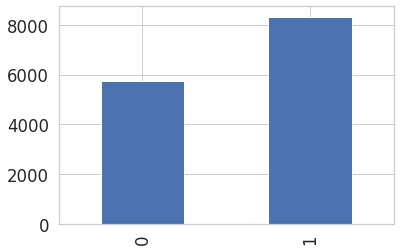

In [ ]:
tweets_validation1_1['Sentimiento'].value_counts().sort_index().plot.bar()

### Segunda arquitectura

In [ ]:
tokenizer = Tokenizer(num_words=12505, split=" ")
tokenizer.fit_on_texts(tweets["Texto"].values)

x2lem = tokenizer.texts_to_sequences(tweets["Texto"].values)
x2lem = pad_sequences(x2lem)
print("Sin tokenizar: ", tweets["Texto"][0], "\n Tokenizado: \n", x2lem[0])
y2lem = tweets['Sentimiento'].values
x2lemtrain, x2lemtest, y2lemtrain, y2lemtest = train_test_split(x2lem, y2lem, test_size = 0.3)

Sin tokenizar:  dejar mirar numero caso positivo ayer numero cti 992 80 
 Tokenizado: 
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0   48  299  484
  106  454  138  484 1403 5279  514]


In [ ]:
model2_1 = tf.keras.models.Sequential()
model2_1.add(tf.keras.layers.Embedding(input_dim=12505, output_dim=256, input_length=x2lem.shape[1]))
model2_1.add(tf.keras.layers.SpatialDropout1D(0.2))
model2_1.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, activation='tanh', return_sequences=True)))#, dropout=0.3, recurrent_dropout=0.3))
model2_1.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation='tanh', return_sequences=True)))##, dropout=0.3, recurrent_dropout=0.3))
model2_1.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh')))##, dropout=0.3, recurrent_dropout=0.2))
model2_1.add(tf.keras.layers.Dense(64, activation='relu'))
model2_1.add(tf.keras.layers.Dense(32, activation='relu'))
model2_1.add(tf.keras.layers.Dropout(0.5))
model2_1.add(tf.keras.layers.Dense(16, activation='relu'))
model2_1.add(tf.keras.layers.Dropout(0.5))
model2_1.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model2_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 35, 256)           3201280   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 35, 256)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 35, 512)           1050624   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 35, 256)           656384    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model2_1.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])

In [ ]:
batch_size = 64
epochs = 100

#Callbacks

EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', #Se monitorea el val_loss
    min_delta = 0.001, #Número que se considera como un cambio significativo
    patience = 20, #Número de epochs sin cambios para detenerse
)
tf.keras.backend.clear_session()
history2_1 = model2_1.fit(x2lemtrain, y2lemtrain, validation_data=(x2lemtest, y2lemtest) ,callbacks=[EarlyStop] ,epochs = epochs, batch_size=batch_size)

Epoch 1/100
84/84 [==============================] - 14s 83ms/step - loss: 0.6857 - accuracy: 0.5571 - val_loss: 0.6076 - val_accuracy: 0.7113
Epoch 2/100
84/84 [==============================] - 5s 58ms/step - loss: 0.5997 - accuracy: 0.6892 - val_loss: 0.4718 - val_accuracy: 0.7487
Epoch 3/100
84/84 [==============================] - 5s 57ms/step - loss: 0.3930 - accuracy: 0.8399 - val_loss: 0.4546 - val_accuracy: 0.7865
Epoch 4/100
84/84 [==============================] - 5s 57ms/step - loss: 0.2781 - accuracy: 0.9071 - val_loss: 0.6214 - val_accuracy: 0.7830
Epoch 5/100
84/84 [==============================] - 5s 57ms/step - loss: 0.1697 - accuracy: 0.9525 - val_loss: 0.8248 - val_accuracy: 0.7765
Epoch 6/100
84/84 [==============================] - 5s 56ms/step - loss: 0.1152 - accuracy: 0.9728 - val_loss: 0.9253 - val_accuracy: 0.7783
Epoch 7/100
84/84 [==============================] - 5s 57ms/step - loss: 0.0911 - accuracy: 0.9787 - val_loss: 1.2894 - val_accuracy: 0.7813
Epoch

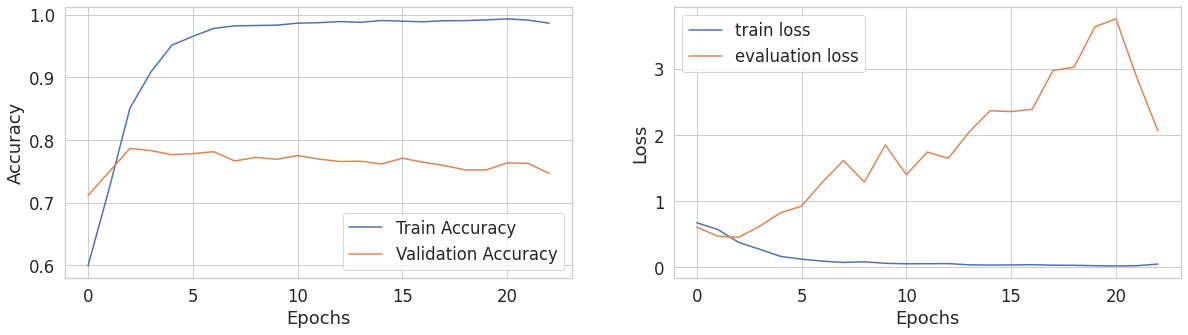

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history2_1.history['accuracy'], label='Train Accuracy');
ax.plot(history2_1.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history2_1.history['loss'], label='train loss');
ax.plot(history2_1.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


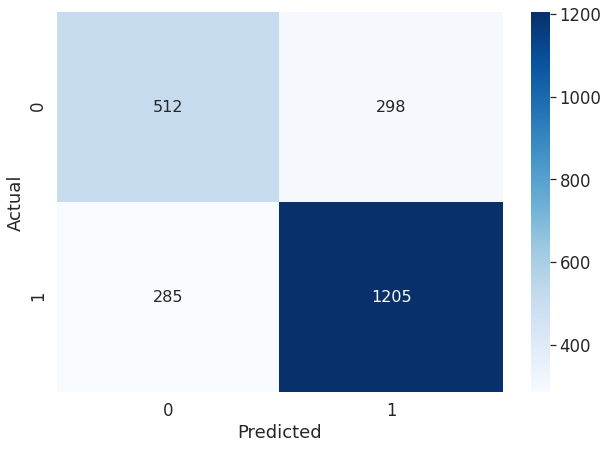

              precision    recall  f1-score   support

           0       0.64      0.63      0.64       810
           1       0.80      0.81      0.81      1490

    accuracy                           0.75      2300
   macro avg       0.72      0.72      0.72      2300
weighted avg       0.75      0.75      0.75      2300



In [ ]:
pred2_1 = model2_1.predict_classes(x2lemtest)
y2_1real = y2lemtest
conf_mx = confusion_matrix(y2_1real, pred2_1)
conf_mx

heat_cm = pd.DataFrame(conf_mx, columns=np.unique(y2_1real), index = np.unique(y2_1real))
heat_cm.index.name = 'Actual'
heat_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.heatmap(heat_cm, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g')# font size
plt.show()
print(metrics.classification_report(y2_1real,pred2_1))

In [ ]:
name_model = 'modelBidirectionalLEM12505'
model2_1.save('models/'+name_model+'.h5')

#### Test the model

In [ ]:
modeloLSTM2_1 = tf.keras.models.load_model('models/modelBidirectionalLEM12505.h5')
tweets_validation2_1 = pd.read_csv('data/data_classifier/tweets_validationCONLEMMA.csv')
tweets_validation2_1["Texto"] = tweets_validation2_1["Texto"].apply(to_str)

In [ ]:
x2_1validation = tokenizer.texts_to_sequences(tweets_validation2_1["Texto"].values)
x2_1validation = pad_sequences(x2_1validation, maxlen=35)
predicciones2_1 = modeloLSTM2_1.predict(x2_1validation)
predicciones2_1

array([[1.0228865e-06],
       [6.5150738e-01],
       [4.4664297e-08],
       ...,
       [2.1296416e-03],
       [8.1861690e-02],
       [2.2477348e-08]], dtype=float32)

In [ ]:
round_predicciones2_1 = []
for i in range(len(predicciones2_1)):
  if predicciones2_1[i]<0.5:
    round_predicciones2_1.append(0)
  else:
    round_predicciones2_1.append(1)

tweets_validation2_1["Sentimiento"] = round_predicciones2_1
tweets_validation2_1.to_csv('data/data_classifier/resultados/tweets_validation_modelBidirectionalLEM12505.csv')
tweets_validation2_1

,Unnamed: 0,Unnamed: 0.1,Nombre de usuario,Usuario,Fecha,Texto,Sentimiento
0,0,0,Bautista Péntecost XY,@BautiPentecost,2021-01-27,vacuna matar gente estar decir,0
1,1,1,Némesis,@MaryBol95533136,2021-01-27,aplicador anales nuevo formar regimen chino so...,1
2,2,2,S A N T I,@diluidoenagua,2021-01-27,encantar tanto gente decir asi si querer ir ll...,0
3,3,3,moon:),@luuunaaaaaaaae,2021-01-27,mejor asi querer vacunar hacer mas rapido,0
4,4,4,Carlos.,@Carloscdc06,2021-01-27,comar mierda hpta,1
...,...,...,...,...,...,...,...
14074,14074,8508,Ells,@ellscms,2020-08-08,pregunta serio tú poneriar vacuna covid si lle...,0
14075,14075,8509,J_Lozano.,@J_LozanoC,2020-08-08,llegar vacuna colombio imaginar cartel covid19,1
14076,14076,8510,Jair G. Camargo R.,@ingeniero0013,2020-08-08,pesar haber ser consentir nacion hoy colombia ...,0
14077,14077,8511,Paradise.,@_DreamWorlds_,2020-08-08,ir llegar colombia vacuna covidoctubre 0 novie...,0


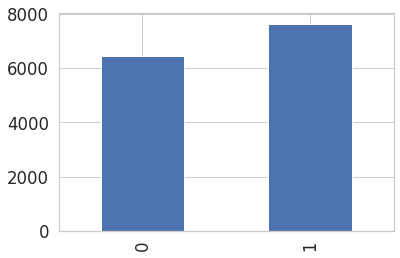

In [ ]:
tweets_validation2_1['Sentimiento'].value_counts().sort_index().plot.bar()

### Tercera arquitectura

In [ ]:
tokenizer3_1 = Tokenizer(num_words=12505, split=" ")
tokenizer3_1.fit_on_texts(tweets["Texto"].values)

x3lem = tokenizer3_1.texts_to_sequences(tweets["Texto"].values)
x3lem = pad_sequences(x3lem)
print("Sin tokenizar: ", tweets["Texto"][0], "\n Tokenizado: \n", x3lem[0])
y3lem = tweets['Sentimiento'].values
x3lemtrain, x3lemtest, y3lemtrain, y3lemtest = train_test_split(x3lem, y3lem, test_size = 0.3)

Sin tokenizar:  dejar mirar numero caso positivo ayer numero cti 992 80 
 Tokenizado: 
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0   48  299  484
  106  454  138  484 1403 5279  514]


In [ ]:
model3_1 = tf.keras.models.Sequential()
model3_1.add(tf.keras.layers.Embedding(input_dim=12505, output_dim=256, input_length=x3lem.shape[1]))
model3_1.add(tf.keras.layers.SpatialDropout1D(0.2))
model3_1.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, activation='tanh', return_sequences=True)))
model3_1.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, activation='tanh', return_sequences=True)))##, dropout=0.3, recurrent_dropout=0.3))
model3_1.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, activation='tanh',return_sequences=True)))
model3_1.add(tf.keras.layers.GlobalMaxPooling1D())
model3_1.add(tf.keras.layers.Dense(256, activation='relu'))
model3_1.add(tf.keras.layers.Dense(32, activation='relu'))
model3_1.add(tf.keras.layers.Dropout(0.5))
model3_1.add(tf.keras.layers.Dense(16, activation='relu'))
model3_1.add(tf.keras.layers.Dropout(0.5))
model3_1.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model3_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 35, 256)           3201280   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 35, 256)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 35, 512)           789504    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 35, 256)           493056    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 35, 128)           123648    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               3

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model3_1.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])

In [ ]:
batch_size = 32
epochs = 100

#Callbacks

EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', #Se monitorea el val_loss
    min_delta = 0.001, #Número que se considera como un cambio significativo
    patience = 20, #Número de epochs sin cambios para detenerse
)
tf.keras.backend.clear_session()
history3_1 = model3_1.fit(x3lemtrain, y3lemtrain, validation_data=(x3lemtest, y3lemtest) ,callbacks=[EarlyStop] ,epochs = epochs, batch_size=batch_size)

Epoch 1/100
168/168 [==============================] - 19s 65ms/step - loss: 0.6373 - accuracy: 0.6428 - val_loss: 0.4870 - val_accuracy: 0.7639
Epoch 2/100
168/168 [==============================] - 8s 50ms/step - loss: 0.5002 - accuracy: 0.7551 - val_loss: 0.4740 - val_accuracy: 0.7578
Epoch 3/100
168/168 [==============================] - 8s 50ms/step - loss: 0.3531 - accuracy: 0.8444 - val_loss: 0.4508 - val_accuracy: 0.7891
Epoch 4/100
168/168 [==============================] - 9s 51ms/step - loss: 0.2545 - accuracy: 0.9170 - val_loss: 0.5877 - val_accuracy: 0.7887
Epoch 5/100
168/168 [==============================] - 9s 52ms/step - loss: 0.1817 - accuracy: 0.9525 - val_loss: 0.6375 - val_accuracy: 0.7796
Epoch 6/100
168/168 [==============================] - 9s 52ms/step - loss: 0.1550 - accuracy: 0.9574 - val_loss: 0.7876 - val_accuracy: 0.7783
Epoch 7/100
168/168 [==============================] - 8s 50ms/step - loss: 0.1151 - accuracy: 0.9711 - val_loss: 0.8128 - val_accuracy

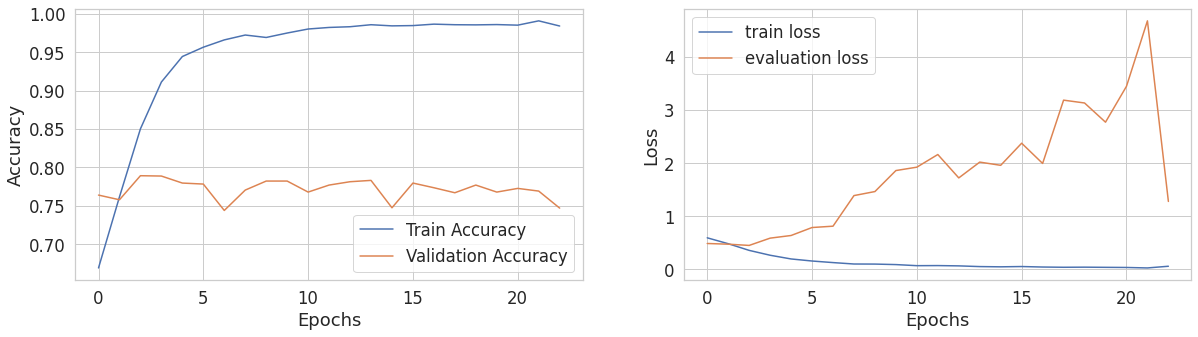

In [ ]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history3_1.history['accuracy'], label='Train Accuracy');
ax.plot(history3_1.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history3_1.history['loss'], label='train loss');
ax.plot(history3_1.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


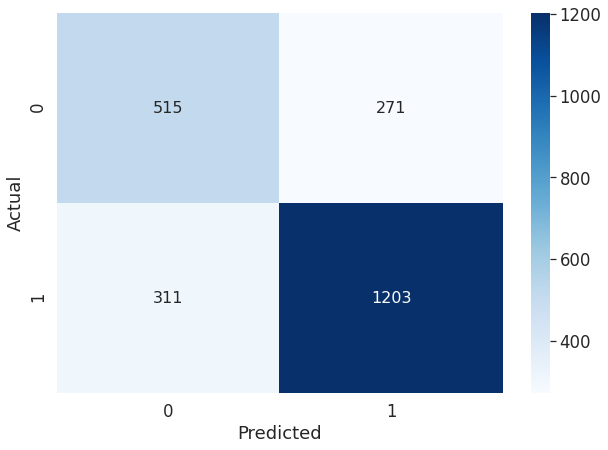

              precision    recall  f1-score   support

           0       0.62      0.66      0.64       786
           1       0.82      0.79      0.81      1514

    accuracy                           0.75      2300
   macro avg       0.72      0.72      0.72      2300
weighted avg       0.75      0.75      0.75      2300



In [ ]:
pred3_1 = model3_1.predict_classes(x3lemtest)
y3_1real = y3lemtest
conf_mx = confusion_matrix(y3_1real, pred3_1)
conf_mx

heat_cm = pd.DataFrame(conf_mx, columns=np.unique(y3_1real), index = np.unique(y3_1real))
heat_cm.index.name = 'Actual'
heat_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.heatmap(heat_cm, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g')# font size
plt.show()
print(metrics.classification_report(y3_1real,pred3_1))

In [ ]:
name_model = 'modelBidirectionalAndMaxLEM12505'
model3_1.save('models/'+name_model+'.h5')

#### Test the model

In [ ]:
modeloLSTM3_1 = tf.keras.models.load_model('models/modelBidirectionalAndMaxLEM12505.h5')
tweets_validation3_1 = pd.read_csv('data/data_classifier/tweets_validationCONLEMMA.csv')
tweets_validation3_1["Texto"] = tweets_validation3_1["Texto"].apply(to_str)
x3_1validation = tokenizer3_1.texts_to_sequences(tweets_validation3_1["Texto"].values)
x3_1validation = pad_sequences(x3_1validation, maxlen=35)
predicciones3_1 = modeloLSTM3_1.predict(x3_1validation)
predicciones3_1

array([[0.56036806],
       [1.        ],
       [0.03471767],
       ...,
       [0.99565   ],
       [0.6152752 ],
       [0.28161058]], dtype=float32)

In [ ]:
round_predicciones3_1 = []
for i in range(len(predicciones3_1)):
  if predicciones3_1[i]<0.5:
    round_predicciones3_1.append(0)
  else:
    round_predicciones3_1.append(1)

tweets_validation3_1["Sentimiento"] = round_predicciones3_1
tweets_validation3_1.to_csv('data/data_classifier/resultados/tweets_validation_modelBidirectionalAndMaxLEM12505.csv')
tweets_validation3_1

,Unnamed: 0,Unnamed: 0.1,Nombre de usuario,Usuario,Fecha,Texto,Sentimiento
0,0,0,Bautista Péntecost XY,@BautiPentecost,2021-01-27,vacuna matar gente estar decir,1
1,1,1,Némesis,@MaryBol95533136,2021-01-27,aplicador anales nuevo formar regimen chino so...,1
2,2,2,S A N T I,@diluidoenagua,2021-01-27,encantar tanto gente decir asi si querer ir ll...,0
3,3,3,moon:),@luuunaaaaaaaae,2021-01-27,mejor asi querer vacunar hacer mas rapido,0
4,4,4,Carlos.,@Carloscdc06,2021-01-27,comar mierda hpta,0
...,...,...,...,...,...,...,...
14074,14074,8508,Ells,@ellscms,2020-08-08,pregunta serio tú poneriar vacuna covid si lle...,0
14075,14075,8509,J_Lozano.,@J_LozanoC,2020-08-08,llegar vacuna colombio imaginar cartel covid19,1
14076,14076,8510,Jair G. Camargo R.,@ingeniero0013,2020-08-08,pesar haber ser consentir nacion hoy colombia ...,1
14077,14077,8511,Paradise.,@_DreamWorlds_,2020-08-08,ir llegar colombia vacuna covidoctubre 0 novie...,1


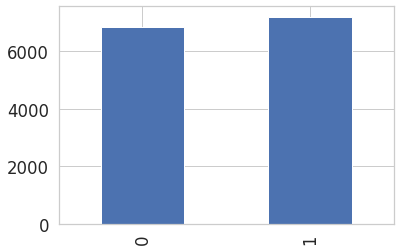

In [ ]:
tweets_validation3_1['Sentimiento'].value_counts().sort_index().plot.bar()

## Extraer vector embebido

Si extraemos el vector embebido, podremos obtener un universo de palabras, las cuales al aplicar un PCA, podremos obtener de una manera más visual la correlación entre palabras. En este caso, utilizaremos tensorboard, debido a que su implementación es sencilla y ofrece mpas ventajas visuales.

In [19]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [20]:
from tensorboard.plugins import projector

In [21]:
words = tokenizer1_1.word_index.keys()
encoder = []
for word in words:
  encoder.append(word)

encoder = encoder[:-1]

Guardamos los metadatos necesarios.

In [23]:
# Set up a logs directory, so Tensorboard knows where to look for files
log_dir='/logs/modelGlobalMaxPooling1DLEM125052/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Save Labels separately on a line-by-line manner.
with open(os.path.join(log_dir, 'metadatamodelGlobalMaxPooling1DLEM12505.tsv'), "w") as f:
  for subwords in encoder:
    f.write("{}\n".format(subwords))
  # Fill in the rest of the labels with "unknown"
  for unknown in range(1, len(encoder) - len(encoder)):
    f.write("unknown #{}\n".format(unknown))


# Save the weights we want to analyse as a variable. Note that the first
# value represents any unknown word, which is not in the metadata, so
# we will remove that value.
weights = tf.Variable(modeloLSTM1_1.layers[0].get_weights()[0][1:])
# Create a checkpoint from embedding, the filename and key are
# name of the tensor.
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embeddingmodelGlobalMaxPooling1DLEM12505.ckpt"))

# Set up config
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadatamodelGlobalMaxPooling1DLEM12505.tsv'
projector.visualize_embeddings(log_dir, config)

A continuación, se podrá apreciar el vector embedido reducido a tres dimensiones. Las palabras entre más cercanas estén, más correlación tienen.

In [27]:
%tensorboard --logdir /logs/modelGlobalMaxPooling1DLEM125052/